## Confirmation Bias Project
#### Behavioural analyses

##### Import important functions and libraries

In [5]:
import os, glob #pip install 
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import scipy.stats as stats
from scipy import signal
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
#import scikit_posthocs as sp
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from matplotlib.lines import Line2D
import statsmodels as sms
pd.options.display.max_columns = None # display all the columns in pandas dataframe
import plotly.graph_objects as go
import plotly.express as px

##### Important functions

In [6]:
def RT_filter(x, sd): 
    # this function is used to filter those trials with a RT that it are below/above X standard deviation from the mean
    rt_mean = x['RT'].mean()
    up_lim = rt_mean + sd * x['RT'].std()
    x = x.loc[(x['RT'] < up_lim) & (x['RT'] > 0), : ]
    return x
def sdt_comp(x): # sdt is used to compute d' and c (even though, it is not used in these analyses)
    phit = x.loc[x.cond == 1,:].deci.mean()
    pfa  = x.loc[x.cond == 0,:].deci.mean() #correct condition to be 0 instead of -1
    # avoiding 0 or 1 probs that lead to infinite values
    if phit == 1: phit = phit - 0.0001
    if phit == 0: phit = phit + 0.0001
    if pfa == 1:  pfa = pfa - 0.0001
    if pfa == 0:  pfa = pfa + 0.0001
    # z transform the scores
    zhit = scipy.stats.norm.ppf(phit, loc=0, scale = 1) 
    zfa  = scipy.stats.norm.ppf(pfa, loc =0, scale = 1)
    dprime = zhit - zfa
    c = -(zhit + zfa)/2
    out = pd.concat([pd.Series(phit, name = "phit"), pd.Series(pfa, name = "pfa"), pd.Series(dprime, name = "dprime"), pd.Series(c, name = "c")], axis = 1)
    #out = out.reset_index()
    return out #dprime, c #
def log_reg_fit(x, f): # this function is used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x).fit()
    params = reg.params
    # concatenating parameters
    out = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]]})
    return out

### Data & variables

In [7]:
#results_path = 'C:/Users/usuario/Dropbox/ConfBiasProject/Analyses/results' #windows             
results_path = '/Users/alex/Dropbox/Projects/Condcision/Behav_data/FirstExperiment/' # mac

os.chdir(results_path) # change the current working directory to the results path 
rdata = pd.DataFrame([]) # concatenate general behav subject data
odata = pd.DataFrame([]) # concatenate here orientation stimuli (the matrix containing the 8 orientations x trial)
ddata = pd.DataFrame([]) # concatenate here orientation stimuli transformed to decision variable subject data (the matrix containing the 8 decisionvariables x trial)
ndata = pd.DataFrame([]) # useful when you named wrongly two datasets with the same name
coudf = pd.DataFrame([]) # concatenate files (alternative way to get the number of participants)
n_trials = 40*3 #trials * number of presentations
count = np.zeros(shape=(n_trials, 1)) #count = np.zeros(shape=(1, 1))
for file in glob.glob("*.psydat"): #si estuviera en un working directory por encima puedo hacer "./subject/*.psydat"
    p_file =  open(os.path.join(results_path, file),"rb")
    count = count + 1
    dat = pickle.load(p_file)
    coudf = pd.DataFrame(count, columns = ['npar'])
    for block in dat['main_exp']['Exp_blocks']:
        rdata = pd.concat([rdata,block['data']], axis = 0) #esta función es la que llena el dataframe con los valores de data
        odata = pd.concat([odata,block['trial_orientations']], axis = 0)
        ddata = pd.concat([ddata,pd.DataFrame(signal.sawtooth(4 * (block['trial_orientations']), 0.5),columns=['d1','d2','d3','d4','d5','d6'])], axis = 0)
        ndata = pd.concat([ndata, coudf], axis = 0) #it provides the real number of participants (one file = one participant)
all_df = pd.concat([ndata, rdata, ddata, odata], axis = 1) #otro data frame con todos los data frames que interesan
all_df.tail()

,npar,subj,nblock,ntrial,nrep,cond,DV,resp,r_map,correct,RT,d1,d2,d3,d4,d5,d6,o1,o2,o3,o4,o5,o6
115,29.0,p27,5,38,1,-1,-0.4,z,0,1,0.645,-0.432654,-0.427042,0.031843,-0.687820,-0.042524,-0.963831,1.348,0.225,1.976,3.019,0.376,1.585
116,29.0,p27,5,38,2,-1,-0.4,m,45,1,2.122,-0.432654,-0.427042,0.031843,-0.687820,-0.042524,-0.963831,1.348,0.225,1.976,3.019,0.376,1.585
117,29.0,p27,5,39,0,-1,-0.3,z,0,1,1.910,-0.397522,-0.131651,-0.872157,0.485116,-0.045589,-0.882862,2.905,0.341,1.621,2.154,1.196,0.046
118,29.0,p27,5,39,1,-1,-0.3,z,0,1,0.559,-0.397522,-0.131651,-0.872157,0.485116,-0.045589,-0.882862,2.905,0.341,1.621,2.154,1.196,0.046
119,29.0,p27,5,39,2,-1,-0.3,z,0,1,0.680,-0.397522,-0.131651,-0.872157,0.485116,-0.045589,-0.882862,2.905,0.341,1.621,2.154,1.196,0.046


### Dataframe experiment 1

In [8]:
df = all_df
df['cond'] = all_df['cond'].replace([-1], 0)
df['correct'] = all_df['correct'].replace([-1], 0)

# Inserting the new necessary columns coding trials properly

df.insert(8, 'deci', 0)

# Criteria to code response type
crit1 = (df['cond']  > 0) & (df['correct'] == 1);    # 0 = diagonal       
crit2 = (df['cond']  < 0) & (df['correct'] == 0);            
crit3 = (df['cond'] == 0) & (df['correct'] == 0);
all_df.loc[crit1 | crit2 | crit3, 'deci'] = 1 

# Inserting the new necessary columns coding trials properly
df.insert(10, 'pre_deci', 0)    # 0 = previous Diag / 1 = previous Card
df.insert(11, 'pre_correct', 0) # O = incorrect / 1 = correct
df.insert(10, 'rDV', 0)

# Insert the previous decision of each trial

df['pre_deci']  = df['deci'] #la variable pre_deci es igual al valor de deci
df['pre_deci'] = df['pre_deci'].shift(1, fill_value  = 0) # al hacer shift, se llena el primer valor con 0 

# Inserting mean DV per trial

df['rDV'] = np.mean(ddata, axis = 1)

# Insert the previous respose, if correct or not

df['pre_correct'] = df['correct']
df['pre_correct'] = df['pre_correct'].shift(1, fill_value  = 0)

df.insert(12, 'first_deci', 0)

df['first_deci']  = df['pre_deci'] #la variable pre_deci es igual al valor de deci
df['first_deci']  = df['first_deci'].shift(1, fill_value  = 0) # decision took 2 presentations earlier

df.insert(13, 'consistent', 0) #0 = none consistent / 1 = consistent

df.loc[(df.pre_deci == 0) & (df.first_deci == 0) | (df.pre_deci == 1) & (df.first_deci == 1), 'consistent'] = 1

df.insert(15, 'first_correct', 0)
df['first_correct']  = df['pre_correct']
df['first_correct'] = df['first_correct'].shift(1, fill_value  = 0) # result 2 presentations earlier

df.insert(16, 'both_correct', 0)
df.loc[(df.pre_correct == 1) & (df.first_correct == 1), 'both_correct'] = 1 # 0 = some errors at 2 previous

df.insert(17, 'both_incorrect', 0)
df.loc[(df.pre_correct == 0) & (df.first_correct == 0), 'both_incorrect'] = 1 # 1 = all errors at 2 previous

df.insert(18, 'first_error', 0)
df.loc[(df.first_correct == 0) & (df.pre_correct == 1), 'first_error'] = 1

df.insert(19, 'second_error', 0)
df.loc[(df.first_correct == 1) & (df.pre_correct == 0), 'second_error'] = 1

df.insert(21, 'repeat', 0)
df.loc[(df.deci == df.pre_deci), 'repeat'] = 1

df.insert(22, 'pre_repeat', 0)
df['pre_repeat']  = df['repeat'] 
df['repeat']  = df['repeat'].shift(1, fill_value  = 0) # al hacer shift, se llena el primer valor con 0

df.insert(23, 'repeat_all', 0)
df.loc[(df.deci == 0) & (df.pre_deci == 0) & (df.first_deci == 0) | (df.deci == 1) & (df.pre_deci == 1) & (df.first_deci == 1), 'repeat_all'] = 1

df.insert(13, 'Expectancy', 'U')
df.loc[(df.pre_deci == 0) & (df.cond==0) | (df.pre_deci == 1) & (df.cond==1), 'Expectancy'] = 'E'

df.head(10) #da los 15 primeros outputs

,npar,subj,nblock,ntrial,nrep,cond,DV,resp,deci,r_map,rDV,pre_deci,first_deci,Expectancy,consistent,pre_correct,first_correct,both_correct,both_incorrect,first_error,second_error,correct,repeat,pre_repeat,repeat_all,RT,d1,d2,d3,d4,d5,d6,o1,o2,o3,o4,o5,o6
0,1.0,p14,0,0,0,0,-0.38,m,0,45,-0.366948,0,0,E,1,0,0,0,1,0,0,1,0,1,1,2.511,-0.581859,-0.985758,0.611403,-0.523808,-0.383752,-0.337915,1.735,3.136,0.938,0.187,0.242,0.260
1,1.0,p14,0,0,1,0,-0.38,z,0,0,-0.366948,0,0,E,1,1,0,0,0,1,0,1,1,1,1,2.051,-0.581859,-0.985758,0.611403,-0.523808,-0.383752,-0.337915,1.735,3.136,0.938,0.187,0.242,0.260
2,1.0,p14,0,0,2,0,-0.38,m,1,0,-0.366948,0,0,E,1,1,1,1,0,0,0,0,1,0,0,2.242,-0.581859,-0.985758,0.611403,-0.523808,-0.383752,-0.337915,1.735,3.136,0.938,0.187,0.242,0.260
3,1.0,p14,0,1,0,0,-0.28,m,0,45,-0.285548,1,0,U,0,0,1,0,0,0,1,1,0,0,0,2.213,0.319595,0.563020,-0.220777,-0.691357,-0.825330,-0.858434,2.089,0.957,0.306,1.692,3.073,3.086
4,1.0,p14,0,1,1,0,-0.28,z,0,0,-0.285548,0,1,E,0,1,0,0,0,1,0,1,0,1,0,1.528,0.319595,0.563020,-0.220777,-0.691357,-0.825330,-0.858434,2.089,0.957,0.306,1.692,3.073,3.086
5,1.0,p14,0,1,2,0,-0.28,m,0,45,-0.285548,0,0,E,1,1,1,1,0,0,0,1,1,1,1,1.269,0.319595,0.563020,-0.220777,-0.691357,-0.825330,-0.858434,2.089,0.957,0.306,1.692,3.073,3.086
6,1.0,p14,0,2,0,1,0.18,z,1,45,0.184199,0,0,U,1,1,1,1,0,0,0,1,1,0,0,1.332,0.507516,-0.006873,-0.019606,0.209578,0.245747,0.168834,0.592,0.390,0.385,0.475,2.060,0.459
7,1.0,p14,0,2,1,1,0.18,z,1,45,0.184199,1,0,E,0,1,1,1,0,0,0,1,0,1,0,1.426,0.507516,-0.006873,-0.019606,0.209578,0.245747,0.168834,0.592,0.390,0.385,0.475,2.060,0.459
8,1.0,p14,0,2,2,1,0.18,z,1,45,0.184199,1,1,E,1,1,1,1,0,0,0,1,1,1,1,1.664,0.507516,-0.006873,-0.019606,0.209578,0.245747,0.168834,0.592,0.390,0.385,0.475,2.060,0.459
9,1.0,p14,0,3,0,0,-0.08,m,1,0,-0.071730,1,1,U,1,1,1,1,0,0,0,0,1,1,1,4.060,-0.016540,0.007368,0.316011,-0.947043,0.117904,0.091921,1.957,2.746,1.054,1.550,0.439,1.142


### All participants are good or it is better to remove some??

In [9]:
print(np.unique(df.npar))
print( )
print("n subjects = " + str(len(np.unique(df.npar))))
print( )
print(list(df.columns))

formula = "deci ~ rDV"
log_par = df.groupby(['npar']).apply(log_reg_fit, formula)
log_par.reset_index(inplace = True)

good_subjs = log_par.loc[log_par.weight > 0.0, : ].npar #it computes weight. Participants with a negative weight were removed

outliers = np.array(good_subjs)

mean = np.mean(outliers, axis=0)
sd = np.std(outliers, axis=0)

final_data = [x for x in outliers if (x > mean - 2 * sd)]
final_data = [x for x in final_data if (x < mean + 2 * sd)] # participants with 2+ sd from the mean were removed
print(final_data); print(len(final_data))

print( )
print("n good participants = " + str(len(final_data)))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]

n subjects = 29

['npar', 'subj', 'nblock', 'ntrial', 'nrep', 'cond', 'DV', 'resp', 'deci', 'r_map', 'rDV', 'pre_deci', 'first_deci', 'Expectancy', 'consistent', 'pre_correct', 'first_correct', 'both_correct', 'both_incorrect', 'first_error', 'second_error', 'correct', 'repeat', 'pre_repeat', 'repeat_all', 'RT', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6']
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0]
29

n good participants = 29


#### Let's remove bad participants

In [10]:
#Keeping only good subjects
df = df[df['npar'].isin(good_subjs)] 
df.reset_index(drop=True, inplace=True)
print(np.unique(df.npar)); print(len(np.unique(df.npar))) 
# Actually, we would not remove any of them, all of them were considere good

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
29


##### dflong

In [11]:
# new dataframe, it measures the particular effect by each stimuli position.
# it allows to measure the effect of each particular stimuli position in the final choice
# and to estimate if previous stimuli affect the final decision
dflong = pd.melt(df, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci', 'pre_correct', 'correct', 'first_deci'], value_vars=['d1', 'd2', 'd3', 'd4', 'd5', 'd6'])
dflong.shape
dflong.rename(columns={'variable' : "stim", 'value' : 'dv'}, inplace=True)

out = pd.melt(df, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci', 'pre_correct', 'correct', 'first_deci'], value_vars=['o1', 'o2', 'o3', 'o4', 'o5', 'o6'])
dflong['orient'] = out.value
del out

dflong.insert(6, 'expected', "U") 
# an stimuli is expected when the previous deci variable and previous deci were the same (i.e.DV==D & pre_deci == D)
dflong.loc[(dflong.pre_deci == 0) & (dflong.dv < 0) | (dflong.pre_deci == 1) & (dflong.dv > 0), "expected"]  = "E"

dflong.insert(4, 'cond', "D")
dflong.loc[(dflong.dv < 0), "cond"]  = "C"

dflong.insert(8, 'pre_expected', "U")
dflong['pre_expected'] = dflong['expected']
dflong['pre_expected'] = dflong['pre_expected'].shift(1, fill_value = "U")

dflong.insert(9, 'cong_long', 0)
# one participant is congruent when the 2 last pre decis and deci variable were the same 
dflong.loc[(dflong.expected == 'U') & (dflong.pre_expected == 'U') | (dflong.expected == 'E') & (dflong.pre_expected == 'E'), 'cong_long'] = 1
#bins <- divids the orientation of the stimuli in small categories. it groups similar oriented stimuli together
dflong['bins'] = pd.cut(x=dflong['dv'], bins=[-0.55, -0.40, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.40, 0.55], labels=[-0.4, -0.30, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4])

print(dflong.head())

formula = "deci ~ dv"
log_regstim_params = dflong.groupby(['npar','nrep', 'stim']).apply(log_reg_fit, formula)
log_regstim_params.reset_index(inplace = True)

   npar  nblock  ntrial  nrep cond  deci  pre_deci expected pre_expected  \
0   1.0       0       0     0    C     0         0        E            U   
1   1.0       0       0     1    C     0         0        E            E   
2   1.0       0       0     2    C     1         0        E            E   
3   1.0       0       1     0    D     0         1        E            E   
4   1.0       0       1     1    D     0         0        U            E   

   cong_long  pre_correct  correct  first_deci stim        dv  orient bins  
0          0            0        1           0   d1 -0.581859   1.735  NaN  
1          1            1        1           0   d1 -0.581859   1.735  NaN  
2          1            1        0           0   d1 -0.581859   1.735  NaN  
3          1            0        1           0   d1  0.319595   2.089  0.3  
4          0            1        1           1   d1  0.319595   2.089  0.3  


### Congruency between series of stimuli

##### Dflong for previous orientations and stimuli

In [12]:
# In this chunk, we will compute two important things. We will group stimuli depending on their similar orientation
# compared with the orientation of the previous stimuli and also, we will group stimuli depending on the previous
# category. Two stimuli would be grouped together if they were preceded by a stimuli from the same category (Diag follwd Diag)

# selecting the stimuli Dv
stim_dec = df[['d1','d2','d3','d4','d5','d6']]
# Simplify the labels
stim_dec[stim_dec > 0] = 1
stim_dec[stim_dec < 0] = 0

diff_stim_dec = np.diff(stim_dec, axis  = 1)
out = abs(pd.DataFrame(diff_stim_dec, index = df.index, columns = ["cd2","cd3","cd4","cd5","cd6"]))

# resetting indexes in order to be able to concatenate the dataframes 
out.reset_index(drop=True, inplace=True)

# concatenating vertically (over columns)
df.reset_index(drop=True, inplace=True)
out.reset_index(drop=True, inplace=True)
out = pd.concat([df, out], axis = 1)
# transforming data to long format
out = pd.melt(out, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci'], value_vars=['cd2', 'cd3', 'cd4', 'cd5', 'cd6'])
out.head()
# dataset removing first stimulus of the sequence in order to append whether the previous stim is congruent or incongruent
dflong_sd = dflong.loc[dflong.stim != "d1", : ]
dflong_sd.reset_index(drop=True, inplace=True)
out.reset_index(drop=True, inplace=True)
dflong_sd = pd.concat([dflong_sd, out.value], axis = 1)

dflong_sd.rename(columns = {'value' : 'pre_stim'}, inplace = True)
#print(dflong_sd.loc[ (dflong_sd.nblock == 1) & (dflong_sd.ntrial == 0) & (dflong_sd.subj == "p01"),:])

#Appending information about the physical difference between the pre-stimulus and current orientation (classifyin in similar & different physically)

stim_ori = df[['o1','o2','o3','o4','o5','o6']]

diff_stim_ori = abs(np.diff(np.rad2deg(stim_ori), axis  = 1))
diff_stim_ori[diff_stim_ori < 67.5] = 0
diff_stim_ori[diff_stim_ori > 67.5] = 1
diff_stim_ori
out = abs(pd.DataFrame(diff_stim_ori, columns = ["co2","co3","co4","co5","co6"]))
#out.head(200)
# concatenating vertically (over columns)
out = pd.concat([df, out], axis = 1)
# transforming data to long format
out = pd.melt(out, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci'], value_vars=["co2","co3","co4","co5","co6"])
out.rename(columns = {'value' : 'pre_orient'}, inplace = True) # if the difference is smaller than 67.5 degrees the stimuli are assumed to be similar

dflong_sd = pd.concat([dflong_sd, out.pre_orient], axis = 1)
dflong_sd.head()

/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/alex/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2983: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

,npar,nblock,ntrial,nrep,cond,deci,pre_deci,expected,pre_expected,cong_long,pre_correct,correct,first_deci,stim,dv,orient,bins,pre_stim,pre_orient
0,1.0,0,0,0,C,0,0,E,E,1,0,1,0,d2,-0.985758,3.136,NaN,0.0,1.0
1,1.0,0,0,1,C,0,0,E,E,1,1,1,0,d2,-0.985758,3.136,NaN,0.0,1.0
2,1.0,0,0,2,C,1,0,E,E,1,1,0,0,d2,-0.985758,3.136,NaN,0.0,1.0
3,1.0,0,1,0,D,0,1,E,E,1,0,1,0,d2,0.563020,0.957,NaN,0.0,0.0
4,1.0,0,1,1,D,0,0,U,E,0,1,1,1,d2,0.563020,0.957,NaN,0.0,0.0


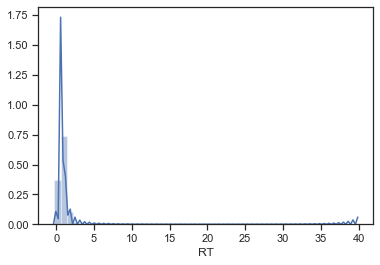

In [13]:
sns.axes_style('white') #RTs
sns.distplot(df.RT)

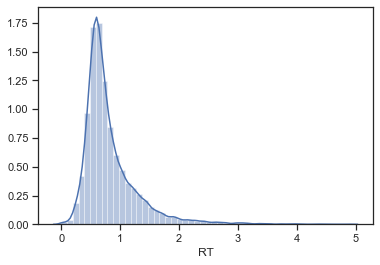

In [14]:
# RT after apply filter
df = df.groupby(['npar'], group_keys = False).apply(RT_filter, sd = 3) #1.5 responses larger 1.5 were removed
sns.distplot(df.RT)

#### Plots experiment 1

<font size="4"> _Porcentaje de respuesta a un estímulo en función de la decision variable y el número de repeticiones._

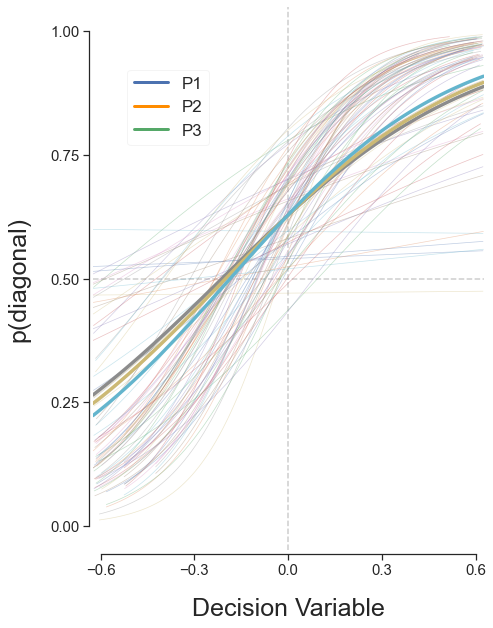

In [15]:
# Repeating the same sequence of stimuli makes the participants' estimation more similar to the real average of the sequence?
# Puede que le tengas que dar a run dos veces para que te haga bien el plot, los colores a lo mejor te salen mal
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar

mycol = ["b", "darkorange", "g"]
sns.set_palette(mycol)
ax = plt.axvline(0, ls='--', color= 'black', alpha=0.2)
ax = plt.axhline(0.5, ls='--', color= 'black', alpha=0.2)
for i in npar_labels: #for loop to compute the average by each participant
    df2=df.loc[df.npar == i,:]
    for cell in nrep_labels:
        sns.set_palette(mycol)
        ax = sns.regplot(x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7}); #mean all subject
for cell in nrep_labels: #for loop to compute the plot by the average sample
    sns.set_palette(mycol)
    ax = sns.regplot(x="rDV", y="deci",  data=df.loc[df.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'lw':3.4}); #mean by participant
sns.despine(offset=4, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)
plt.savefig('deci_x_nrep.png')


In [16]:
# make the model to estimate if there are statistical differences at the slope (weight) or the intercept of the last plot
formula = "deci ~ rDV"
log_reg_nrep = df.groupby(['npar', 'nrep']).apply(log_reg_fit, formula)
log_reg_nrep.reset_index(inplace = True)
log_reg_nrep.head()

,npar,nrep,level_2,intercept,weight
0,1.0,0,0,0.514372,0.942381
1,1.0,1,0,0.567786,1.111218
2,1.0,2,0,0.522905,1.060494
3,2.0,0,0,0.590424,0.954785
4,2.0,1,0,0.604906,0.936048


In [17]:
#Checking statistical differences in Weight between the number of repetitions
pg.rm_anova(dv = 'weight', within = ['nrep'], subject = 'npar', data=log_reg_nrep, detailed = True, correction = True)
#Alexis, el W-spher es el p-value de sphericity? Porque si es así, no hay que hacer la corrección

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,nrep,0.088,2,0.044,12.231,3.91373e-05,7.29288e-05,0.304,0.915,True,0.907,0.269563
1,Error,0.202,56,0.004,-,-,-,-,-,-,-,-


__AQUI FALTA:__

Plotear los parametros bias y weight en diferentes figuras, media del grupo y de cada sujeto para condicion. Adenás faltarían los post-hoc t-tests porque sabemos que hay un main efecto de repeticion para weights, pero no sabemos que lo esta causando. El pinguin creo que te lo hace todo al correr el anova. Además también te da valores como el tamaño del efecto, bayes factor, etc.

In [18]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within='nrep', subject='npar', padjust='fdr_bh', tail='two-sided', effsize = 'cohen', data=log_reg_nrep) 
#he ajustado los p-value con bonferroni y he puesto one-sided porque en nuestras hipótesis a más repes, más efecto, el effect size con eta^2

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,-2.138,28.0,two-sided,0.041353,0.041353,fdr_bh,1.41,-0.121
1,nrep,0,2,True,True,-4.593,28.0,two-sided,0.000084,0.000253,fdr_bh,304.61,-0.259
2,nrep,1,2,True,True,-3.179,28.0,two-sided,0.003590,0.005385,fdr_bh,10.943,-0.131


In [19]:
#Checking statistical differences in Intercept between the number of repetitions
pg.rm_anova(dv = 'intercept', within = ['nrep'], subject = 'npar', data=log_reg_nrep, detailed = True, correction = True)

/Users/alex/anaconda3/lib/python3.7/site-packages/pingouin/distribution.py:955: RuntimeWarning:

divide by zero encountered in double_scalars



,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,nrep,0.000,2,0.000,0.273,0.762063,0.733388,0.01,0.877,True,inf,1
1,Error,0.031,56,0.001,-,-,-,-,-,-,-,-


__Cosas que faltan y ahora están__
Plotear los parametros bias y weight en diferentes figuras

<font size="3"> _Weight y bias ploteados en diferentes figuras_

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

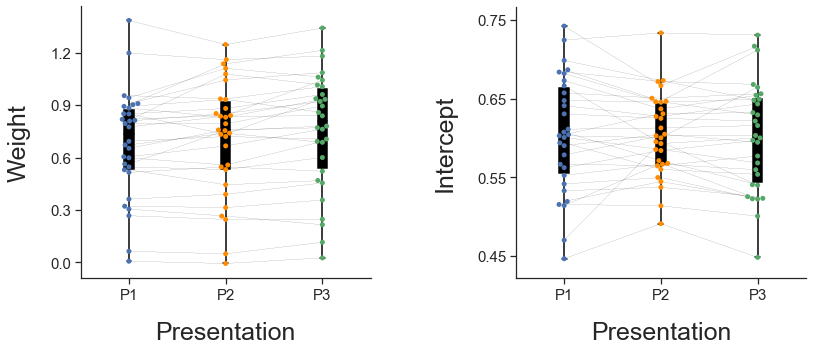

In [16]:
plt.subplots(ncols=2, figsize=(13, 5))
plt.subplots_adjust(wspace = 0.5)

mycol = ["b", "darkorange", "g"]
sns.set_palette(mycol)

plt.subplot(1, 2, 1)  #plt.figure(figsize=(2,5))
ax1 = sns.swarmplot(x="nrep", y="weight", data=log_reg_nrep)
ax1 = sns.boxplot(x="nrep", y="weight", data=log_reg_nrep, whis=np.inf, width = 0.1, color = "black") # , boxprops=dict(alpha=.3)
ax1 = sns.lineplot(x="nrep", y="weight", data=log_reg_nrep, units="npar",  estimator=None, lw = 0.1, color = "black")
sns.despine(ax=ax1, top=True);
plt.ylabel('Weight', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.3, step=0.3), fontsize = 15) 
plt.xlabel('Presentation', fontdict={'size':25}, labelpad=20); plt.xticks(fontsize = 15); ax1.set_xticklabels(['P1', 'P2', 'P3']);
plt.subplot(1, 2, 2) 
ax = sns.swarmplot(x="nrep", y="intercept", data=log_reg_nrep)
ax = sns.boxplot(x="nrep", y="intercept", data=log_reg_nrep, whis=np.inf, width = 0.1, color = "black") # , boxprops=dict(alpha=.3)
ax = sns.lineplot(x="nrep", y="intercept", data=log_reg_nrep, units="npar",  estimator=None, lw = 0.1, color = "black")
sns.despine(ax=ax, top=True);
plt.ylabel('Intercept', fontsize = 25, labelpad=20); plt.yticks(np.arange(0.45, 0.81, step=0.1), fontsize = 15) 
plt.xlabel('Presentation', fontdict={'size':25}, labelpad=20); ax.set_xticklabels(['P1', 'P2', 'P3']); plt.xticks(fontsize = 15)

In [180]:
# previous plot with plotly (weight)

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
dat = log_reg_nrep

fig.add_trace(
    go.Scatter( #lineplot for different category
    y=dat['weight'],
    x=dat['nrep'],
    line=dict(
        color='#C6C2C2',
        width=0.2)))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==0,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    marker_color = 'rgba(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==1,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    marker_color = 'rgba(232, 126, 4, 1)', 
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==2,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    marker_color = 'rgba(0.3333333333333333, 0.6588235294117647, 0.40784313725490196, 1)',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'),
    yaxis_title="Weight",
    showlegend= False,
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

In [169]:
# previous plot with plotly (intercept)

fig = go.Figure()

dat = log_reg_nrep
fig.add_trace(
    go.Scatter( #lineplot for different category
    y=dat['intercept'],
    x=dat['nrep'],
    line=dict(
        color='#C6C2C2',
        width=0.2)))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==0,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    marker_color = 'rgba(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==1,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    marker_color = 'rgba(232, 126, 4, 1)', 
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==2,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    marker_color = 'rgba(0.3333333333333333, 0.6588235294117647, 0.40784313725490196, 1)',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'),
    yaxis_title="Intercept",
    showlegend= False,
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

<font size="4"> _Porcentaje de respuesta a un estímulo en función de la decision variable y la decisión previa_

Text(0, 0.5, '')

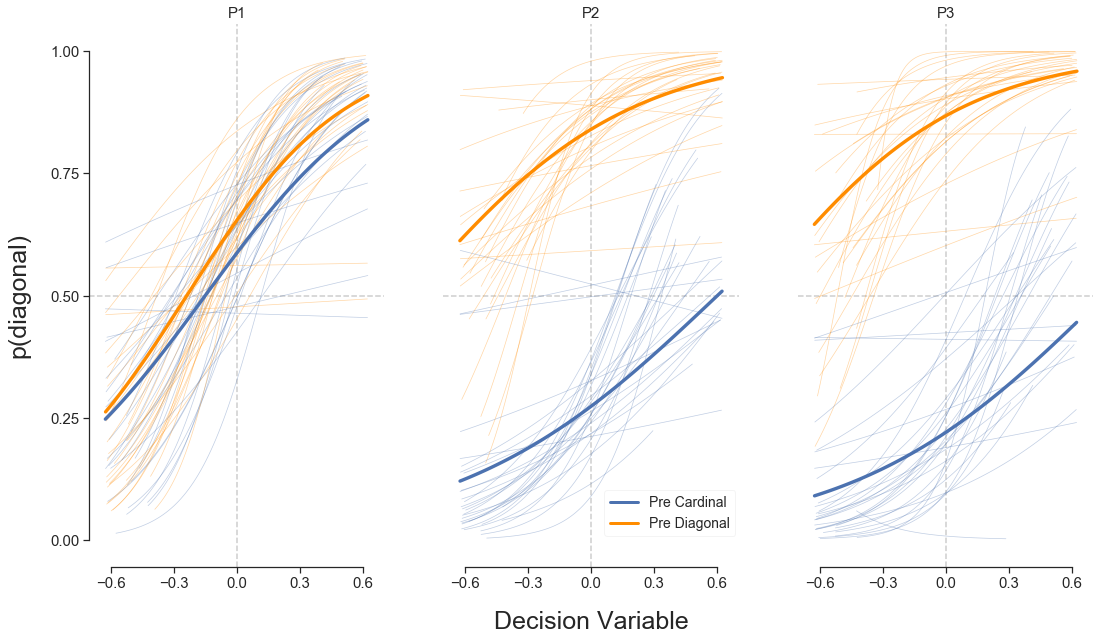

In [17]:
# Previous decisions biases the next response? Previous decision might bias how we estimate the next presentation
# of the trial. Let's find out if previous cardinal decision generates different probabilities to answer diagonal 
# compared with when they previously responded diagonal to equivalent sequences

pre_deci_labels = np.unique(df.pre_deci)     #pre_deci
plt.subplots(ncols=2, figsize=(18, 10))
mycol = ["b", "darkorange"]
sns.set_palette(mycol)
#plt.suptitle("DV for previous decision for the different repetitions", fontsize=20)
plt.subplot(1, 3, 1)
ax0 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax0 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for i in npar_labels: #this for loop makes the plot for each participant for P1
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax0 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 0),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
for cell in pre_deci_labels: #to compute the average for P1
    ax0 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 0),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4}); # O = at lest 1 incorrect answers in this trial ; 1 = both previous answers correct
sns.despine(ax= ax0, offset=0, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15); plt.title('P1', fontsize= 15); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15); plt.xlabel(' ', fontsize = 0)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['Pre Cardinal', 'Pre Diagonal']; #plt.legend(lines, labels, bbox_to_anchor=(0.49,0.15), fontsize=14, framealpha= 0.2)

plt.subplot(1, 3, 2)
ax1 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax1 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for cell in pre_deci_labels: #to compute the average for P2
    ax1 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 1),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4}); # O = changes in the previous decision ; 1 = consistent in both decisions  
for i in npar_labels: #this for loop makes the plot for each participant for P2
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax1 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 1),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
sns.despine(ax= ax1, offset=0, trim=True);
sns.despine(ax=ax1, left=True)
plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15); plt.title('P2', fontsize= 15); plt.yticks([], []); plt.ylabel('', fontsize = 0)
plt.legend(lines, labels, bbox_to_anchor=(0.52,0.1), fontsize=14, framealpha= 0.2)


plt.subplot(1, 3, 3)
ax2 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax2 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for cell in pre_deci_labels: #to compute the average for P3
    ax2 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 2),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4}); # O = changes in the previous decision ; 1 = consistent in both decisions  
for i in npar_labels: #this for loop makes the plot for each participant for P3
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax2 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 2),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
#sns.despine(left=True);
sns.despine(ax= ax2, offset=0, trim=True);
sns.despine(ax=ax2, left=True)
plt.title('P3', fontsize=15); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15); plt.yticks([], []); plt.xlabel(' ', fontsize = 0); plt.ylabel('', fontsize = 0)
#sns.despine(ax=ax, right=True, left=True)
#plt.savefig('predeci.png')

In [18]:
# The differences in the previous plot are significant?
formula = "deci ~ rDV"
log_reg_preDeci = df.groupby(['npar', 'nrep', 'pre_deci']).apply(log_reg_fit, formula)
log_reg_preDeci.reset_index(inplace = True)
log_reg_preDeci.head()

,npar,nrep,pre_deci,level_3,intercept,weight
0,1.0,0,0,0,0.604123,0.642526
1,1.0,0,1,0,0.644931,0.660138
2,1.0,1,0,0,0.397771,0.712483
3,1.0,1,1,0,0.806646,0.377434
4,1.0,2,0,0,0.310657,0.466384


<font size="3"> ANOVAs y post-hoc t-test

In [19]:
#Checking statistical differences in Weight between the number of repetitions & previous decision
pg.rm_anova(dv = 'weight', within = ['nrep', 'pre_deci'], subject = 'npar', data=log_reg_preDeci, detailed = True, correction = True)
#Alexis, el W-spher es el p-value de sphericity? Porque si es así, no hay que hacer la corrección. Cogería el valor de 'p-unc', no?

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,4.550,2,58,2.275,51.651,1.311673e-13,2.392161e-10,0.640,0.713
1,pre_deci,0.315,1,29,0.315,8.251,7.541429e-03,7.541429e-03,0.221,1.000
2,nrep * pre_deci,0.311,2,58,0.155,7.833,9.741527e-04,1.810708e-03,0.213,0.860


In [20]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
pg.pairwise_ttests(dv='weight', within= ['nrep', 'pre_deci'], subject='npar', padjust='bonf', tail='one-sided', interaction=False, effsize = 'eta-square', data=log_reg_preDeci) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,eta-square
0,nrep,0,1,True,True,7.844,29.0,one-sided,5.949087e-09,1.784726e-08,bonf,2.205e+06,0.287
1,nrep,0,2,True,True,7.620,29.0,one-sided,1.057615e-08,3.172845e-08,bonf,1.285e+06,0.364
2,nrep,1,2,True,True,2.038,29.0,one-sided,2.536315e-02,7.608945e-02,bonf,2.366,0.020
3,pre_deci,0,1,True,True,2.872,29.0,one-sided,3.770714e-03,NaN,NaN,11.447,0.040


In [21]:
#Checking statistical differences in Intercept between the number of repetitions & previous decision
pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_deci'], subject = 'npar', data=log_reg_preDeci, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.084,2,58,0.042,14.082,1.035217e-05,4.786967e-05,0.327,0.822
1,pre_deci,6.210,1,29,6.210,339.039,1.523865e-17,1.523865e-17,0.921,1.000
2,nrep * pre_deci,2.556,2,58,1.278,177.218,1.968089e-25,1.415103e-16,0.859,0.616


In [22]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'pre_deci'], subject='npar', padjust='bonf', tail='one-sided', interaction=False, effsize = 'eta-square', data=log_reg_preDeci) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,eta-square
0,nrep,0,1,True,True,3.271,29.0,one-sided,1.383315e-03,0.004150,bonf,27.156,0.111
1,nrep,0,2,True,True,5.734,29.0,one-sided,1.654829e-06,0.000005,bonf,1.167e+04,0.141
2,nrep,1,2,True,True,1.237,29.0,one-sided,1.129937e-01,0.338981,bonf,0.777,0.013
3,pre_deci,0,1,True,True,-18.413,29.0,one-sided,7.619326e-18,NaN,NaN,6.477e+14,0.868


<font size="4"> _Porcentaje de bias generado por la primera y la seguna presentación en la úlitma presentación del estímulo_

C:\Users\usuario\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:894: RuntimeWarning:

invalid value encountered in true_divide



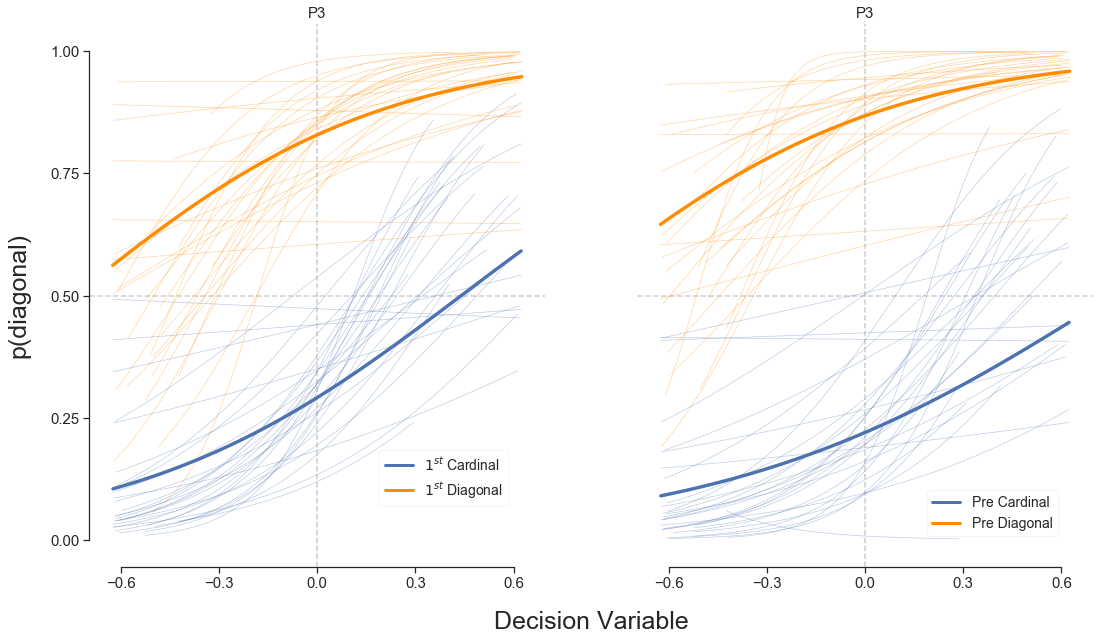

In [179]:
# First decisions biases the response at the 3rd presentation? If participants respond diagonal in the first presentation,
# they would be also biased to answer diagonal in the last presentation? 

pre_deci_labels = np.unique(df.pre_deci)     #pre_deci
fig = plt.subplots(ncols=2, figsize=(18, 10))
mycol = ["b", "darkorange"]
#mycol = ['rgba(162, 222, 208, 1)', 'rgba(27, 163, 156, 1)']
sns.set_palette(mycol)
#plt.suptitle("DV for previous decision for the different repetitions", fontsize=20)
fig = plt.subplot(1, 2, 1) #if participants decision at P1 biases the response at P3
ax1 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax1 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for i in npar_labels: #to compute the average by each participant
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax1 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.first_deci == cell) & (df2.nrep == 2),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
for cell in pre_deci_labels: #to compute the average by all the sample
    ax1 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.first_deci == cell) & (df.nrep == 2),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4}); # O = at lest 1 incorrect answers in this trial ; 1 = both previous answers correct
sns.despine(ax= ax1, offset=0, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15); plt.title('P3', fontsize= 15); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15); plt.xlabel(' ', fontsize = 0)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['$1^{st}$ Cardinal', '$1^{st}$ Diagonal']; #plt.legend(lines, labels, bbox_to_anchor=(0.49,0.15), fontsize=14, framealpha= 0.2)
plt.legend(lines, labels, bbox_to_anchor=(0.62,0.1), fontsize=14, framealpha= 0.2); plt.xlabel('Decision Variable', x=1.1, fontdict={'size':25}, labelpad=20); 

fig = plt.subplot(1, 2, 2) #if participants decision at P1 biases the response at P3
ax2 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax2 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for cell in pre_deci_labels: #to compute the average by all the sample
    ax2 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 2),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4}); # O = changes in the previous decision ; 1 = consistent in both decisions  
for i in npar_labels: #to compute the average by each participant
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax2 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 2),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
sns.despine(ax= ax2, offset=0, trim=True);
sns.despine(ax=ax2, left=True);
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['Pre Cardinal', 'Pre Diagonal']; plt.title('P3', fontsize= 15);
plt.legend(lines, labels, bbox_to_anchor=(0.62,0.1), fontsize=14, framealpha= 0.2); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15); plt.yticks([], []); plt.ylabel('', fontsize = 0); plt.xlabel('', x=1.1, fontdict={'size':1}, labelpad=1); 

#plt.savefig('first_deci_pre_deci_afect_3rdpresenation.png')

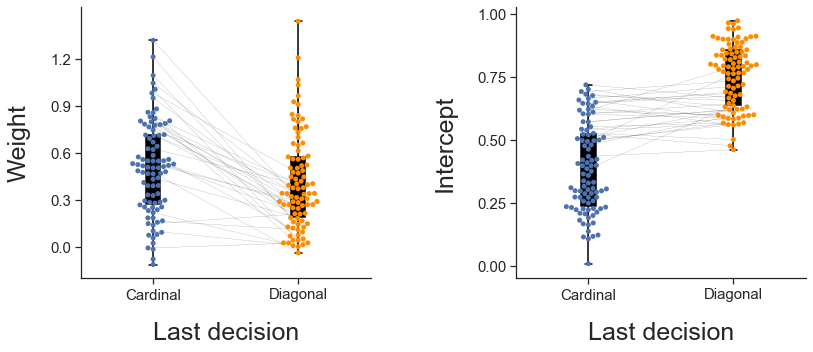

In [30]:
plt.subplots(ncols=2, figsize=(13, 5))
plt.subplots_adjust(wspace = 0.5)

mycol = ["b", "darkorange", "g"]
sns.set_palette(mycol)

plt.subplot(1, 2, 1)  #plt.figure(figsize=(2,5))
#plt.subplot(figsize=(2,5))
ax1 = sns.swarmplot(x="pre_deci", y="weight", data=log_reg_preDeci)
ax1 = sns.boxplot(x="pre_deci", y="weight", data=log_reg_preDeci, whis=np.inf, width = 0.1, color = "black") # , boxprops=dict(alpha=.3)
ax1 = sns.lineplot(x="pre_deci", y="weight", data=log_reg_preDeci, units="npar",  estimator=None, lw = 0.1, color = "black")
sns.despine(ax=ax1, top=True);
plt.ylabel('Weight', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.3, step=0.3), fontsize = 15) 
plt.xlabel('Last decision', fontdict={'size':25}, labelpad=20); plt.xticks(fontsize = 15); ax1.set_xticklabels(['Cardinal', 'Diagonal']);

plt.subplot(1, 2, 2) 
ax = sns.swarmplot(x="pre_deci", y="intercept", data=log_reg_preDeci)
ax = sns.boxplot(x="pre_deci", y="intercept", data=log_reg_preDeci, whis=np.inf, width = 0.1, color = "black") # , boxprops=dict(alpha=.3)
ax = sns.lineplot(x="pre_deci", y="intercept", data=log_reg_preDeci, units="npar",  estimator=None, lw = 0.1, color = "black")
sns.despine(ax=ax, top=True);
plt.ylabel('Intercept', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
plt.xlabel('Last decision', fontdict={'size':25}, labelpad=20); plt.xticks(fontsize = 15); ax.set_xticklabels(['Cardinal', 'Diagonal']);

In [176]:
#previous plot with plotly

# previous plot with plotly (weight)

# Stimulus following one from the same category (i.e. Diagonal & Diagonal) are weighted more than others
# preceded by stimuli from different categories?

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
dat = log_reg_preDeci

fig.add_trace(
    go.Scatter( #lineplot for different category
    y=dat['weight'],
    x=dat['pre_deci'],
    line=dict(
        color='#C6C2C2',
        width=0.2)))

dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci ==0,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['pre_deci'],
    boxpoints='all',
    marker_color = 'rgba(162, 222, 208, 1)',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci ==1,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['pre_deci'],
    boxpoints='all',
    marker_color = 'rgba(27, 163, 156, 1)', 
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))


fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Cardinal', 'Diagonal'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'),
    title='Previous response',
    yaxis_title="Weight",
    showlegend= False,
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

In [203]:
#by number of repetitions
fig = go.Figure()

dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(162, 222, 208, 1)'))
#0A4893


dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Diagonal', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='rgba(27, 163, 156, 1)'
))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(
    boxmode='group', # group together boxes of the different traces for each value of x
    bargroupgap=0.1,
    bargap=1,
    yaxis_title="Weight",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

In [177]:
#previous plot with plotly

# previous plot with plotly (weight)

# Stimulus following one from the same category (i.e. Diagonal & Diagonal) are weighted more than others
# preceded by stimuli from different categories?

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
dat = log_reg_preDeci

fig.add_trace(
    go.Scatter( #lineplot for different category
    y=dat['intercept'],
    x=dat['pre_deci'],
    line=dict(
        color='#C6C2C2',
        width=0.2)))

dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci ==0,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['pre_deci'],
    boxpoints='all',
    marker_color = 'rgba(162, 222, 208, 1)',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci ==1,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['pre_deci'],
    boxpoints='all',
    marker_color = 'rgba(27, 163, 156, 1)', 
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))


fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Cardinal', 'Diagonal'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'),
    yaxis_title="Intercept",
    title = 'Previous response',
    showlegend= False,
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)


fig.update_traces(showlegend=True)

fig.show()

In [206]:
#by number of repetitions
fig = go.Figure()

dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(162, 222, 208, 1)'))
#0A4893


dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Diagonal', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='rgba(27, 163, 156, 1)'
))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(
    boxmode='group', # group together boxes of the different traces for each value of x
    bargroupgap=0.1,
    bargap=1,
    yaxis_title="Intercept",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

In [31]:
# Again, we generate a model that represent the last plot. In this case, the next model just represent the previous left plot.
formula = "deci ~ rDV"
log_reg_pre_first = df.loc[df.nrep == 2,:].groupby(['npar', 'first_deci']).apply(log_reg_fit, formula) 
log_reg_pre_first.reset_index(inplace = True)
log_reg_pre_first.head()

,npar,first_deci,level_2,intercept,weight
0,1.0,0,0,0.399718,0.719488
1,1.0,1,0,0.797925,0.399850
2,2.0,0,0,0.210443,0.495319
3,2.0,1,0,0.787335,0.575078
4,3.0,0,0,0.420838,0.766213


<font size="3"> t-test para la influencia de la 1a presentación en la última

__Que significan los resultados en general? t.tests. Tendría que haber interaccion en el anova tambien, no? es decir, meter pre_deci en el analisis__

**Respuesta:** He cambiado los anova por t test, lo único que no puedo es incluir los pre_deci. Peta la función log_reg_pre_first si la meto

In [32]:
#Checking statistical differences in Weight between the number of repetitions & the first decision
#pg.rm_anova(dv = 'weight', within = ['first_deci'], subject = 'npar', data=log_reg_pre_first, detailed = True, correction = True)
pg.pairwise_ttests(dv='weight', within= ['first_deci'], subject='npar', padjust='none', tail='one-sided', interaction=False, effsize = 'eta-square', data=log_reg_pre_first) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,eta-square
0,first_deci,0,1,True,True,3.866,29.0,one-sided,0.000288,108.105,0.106


In [33]:
#Checking statistical differences in Intercept between the number of repetitions & the first decision
#pg.rm_anova(dv = 'intercept', within = ['first_deci'], subject = 'npar', data=log_reg_pre_first, detailed = True, correction = True)
pg.pairwise_ttests(dv='intercept', within= ['first_deci'], subject='npar', padjust='none', tail='one-sided', interaction=False, effsize = 'eta-square', data=log_reg_pre_first) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,eta-square
0,first_deci,0,1,True,True,-16.634,29.0,one-sided,1.133343e-16,4.86e+13,0.864


<font size="4"> _Weight y bias en función de si la secuencia era esperada por el participante_
    
    Una secuencia era esperada cuando la respuesta previa del participante era la misma que el estímulo que se presentaba ahora

In [236]:
# Again, we generate a model that represent the last plot. In this case, the next model just represent the previous left plot.
formula = "deci ~ rDV"
log_reg_expect = df.loc[df.pre_deci == 0].groupby(['npar', 'Expectancy', 'nrep']).apply(log_reg_fit, formula) 
log_reg_expect.reset_index(inplace = True)
log_reg_expect.head()

,npar,Expectancy,nrep,level_3,intercept,weight
0,1.0,E,0,0,0.661786,0.747514
1,1.0,E,1,0,0.192155,0.092623
2,1.0,E,2,0,0.196367,0.137253
3,1.0,U,0,0,0.524753,0.811013
4,1.0,U,1,0,0.116023,1.819880


In [ ]:
#by number of repetitions
fig = go.Figure()

dat = log_reg_expect.loc[(log_reg_expect.Expectancy == 'E'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Expected', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(162, 222, 208, 1)'))
#0A4893


dat = log_reg_expect.loc[(log_reg_expect.Expectancy == 'U'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Unexpected', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='rgba(27, 163, 156, 1)'
))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(
    boxmode='group', # group together boxes of the different traces for each value of x
    bargroupgap=0.1,
    bargap=1,
    yaxis_title="Weight",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

In [ ]:
pg.rm_anova(dv = 'weight', within = ['Expectancy','nrep'], subject = 'npar', data=log_reg_expect, detailed = True, correction = True)

In [232]:
fig = go.Figure()

dat = log_reg_expect.loc[(log_reg_expect.Expectancy == 'E'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Expected', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(162, 222, 208, 1)'))
#0A4893


dat = log_reg_expect.loc[(log_reg_expect.Expectancy == 'U'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Unexpected', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='rgba(27, 163, 156, 1)'
))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(
    boxmode='group', # group together boxes of the different traces for each value of x
    bargroupgap=0.1,
    bargap=1,
    yaxis_title="Intercept",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

In [227]:
pg.rm_anova(dv = 'weight', within = ['Expectancy','nrep'], subject = 'npar', data=log_reg_expect, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Expectancy,42.094,1,29,42.094,119.087,8.774695e-12,8.774695e-12,0.804,1.000
1,nrep,4.559,2,58,2.279,35.284,9.431392e-11,6.417483e-09,0.549,0.786
2,Expectancy * nrep,17.869,2,58,8.935,86.775,3.670723e-18,1.315543e-12,0.750,0.650


#### Plots experiment 1: long

<font size="3"> _Logisitc regression para plotear weight e intercept en función de la condición anterior_

In [34]:
# The next model checks if stimuli are weigthed/change their intercept depending on the category of previous
# stimuli inside a sequence. For example, if a stimuli is followed from another stimui from the same category,
# for example (diagonal stimuli followed by another diagonal stimuli), the second diagonal stimuli can be 
# weighted more compared when it was preceded by a cardinal stimuli
formula = "deci ~ dv"

log_regpre_deci_params = dflong_sd.groupby(['npar', 'nrep', 'pre_stim']).apply(log_reg_fit, formula)
log_regpre_deci_params.reset_index(inplace = True)
log_regpre_deci_params.head()

,npar,nrep,pre_stim,level_3,intercept,weight
0,1.0,0,0.0,0,0.606535,0.342138
1,1.0,0,1.0,0,0.678612,0.076477
2,1.0,1,0.0,0,0.623368,0.386239
3,1.0,1,1.0,0,0.656819,0.101203
4,1.0,2,0.0,0,0.614605,0.412952


### Plots that represent differences inside the trials 

<font size="4"> _Weight y bias juntos en función de si la condición se repite o no y el número de repetición_

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

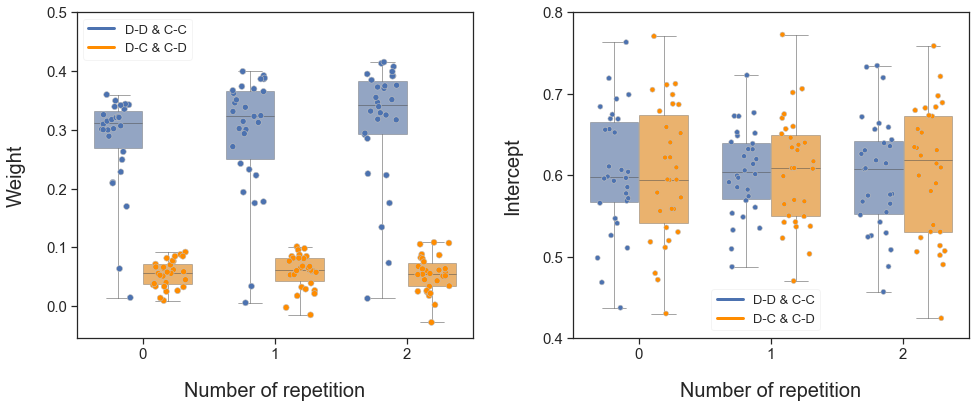

In [35]:
#These subplots are the original plots with seaborn. The next ones, are the plots improved using Plolty
plt.subplots(ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace = 0.25)
dat = log_regpre_deci_params
mycol = ['b', 'darkorange']
plt.subplot(1, 2, 1)  

ax = sns.boxplot(x="nrep", y="weight", hue = dat.pre_stim, linewidth = 0.5, dodge=True, data=dat, whis=np.inf, width = 0.75, boxprops=dict(alpha=.65), palette = mycol) # 
ax = sns.stripplot(x="nrep", y="weight", hue = dat.pre_stim, dodge=True, jitter = .25, data=dat, linewidth =.55, size=6, marker="o", edgecolor="silver", alpha=1, palette = mycol)
plt.ylabel('Weight', fontsize = 20, labelpad=20); plt.yticks(np.arange(0, 0.51, step=0.1), fontsize = 15)
plt.xlabel('Number of repetition', fontdict={'size':20}, labelpad=20); plt.xticks(fontsize = 15)
ax.get_legend().remove()
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['D-D & C-C', 'D-C & C-D']; plt.legend(lines, labels, loc= 'upper left', fontsize=13, framealpha= 0.2)

plt.subplot(1, 2, 2)  #plt.figure(figsize=(2,5))
ax = sns.boxplot(x="nrep", y="intercept", hue = dat.pre_stim, linewidth = 0.5, dodge=True, data=dat, whis=np.inf, width = 0.75, boxprops=dict(alpha=.65), palette = mycol) # 
ax = sns.stripplot(x="nrep", y="intercept", hue = dat.pre_stim, dodge=True, jitter = .25, data=dat, linewidth =.55, size=5, marker="o", edgecolor="silver", alpha=1, palette = mycol)
ax.get_legend().remove()
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['D-D & C-C', 'D-C & C-D']; plt.legend(lines, labels, bbox_to_anchor=(0.64,0.17), fontsize=13, framealpha= 0.2)
plt.ylabel('Intercept', fontsize = 20, labelpad=20); plt.yticks(np.arange(0.4, 0.81, step=0.1), fontsize = 15); plt.xlabel('Number of repetition', fontdict={'size':20}, labelpad=20); plt.xticks(fontsize = 15)

<font size="4"> _Weight en función de si la condición se repite o no y el número de repetición._

In [200]:
# Stimulus following one from the same category (i.e. Diagonal & Diagonal) are weighted more than others
# preceded by stimuli from different categories?

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
data = log_regpre_deci_params
dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='D-D & C-C', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#2A88D4'))
#0A4893


dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='D-C & C-D', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#FA920A'
))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(
    boxmode='group', # group together boxes of the different traces for each value of x
    bargroupgap=0.1,
    bargap=1,
    yaxis_title="Weight",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

<font size="3"> ANOVAs y post-hoc t-test para weight

In [37]:
#Checking statistical differences in Weight between the number of repetitions & the previous stimulus
# If there are differences after adreesing the ANOVA, the differences that we saw at the plot are significant

aov_preor_weight = AnovaRM(log_regpre_deci_params, 'weight', 'npar', within = ['nrep', 'pre_stim']).fit()
#print(aov_preor_weight) 
pg.rm_anova(dv = 'weight', within = ['pre_stim','nrep'], subject = 'npar', data=log_regpre_deci_params, detailed = True, correction = True)

# Esto significa que si se presenta un estímulo y otro seguido de la misma categoría, el siguiente tiene más weight
# el efecto se incrementa con el número de repeticiones

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,pre_stim,2.636,1,29,2.636,266.128,3.780557e-16,3.780557e-16,0.902,1.000
1,nrep,0.006,2,58,0.003,5.638,5.788577e-03,7.606492e-03,0.163,0.905
2,pre_stim * nrep,0.008,2,58,0.004,11.878,4.747642e-05,1.191714e-04,0.291,0.872


In [88]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['pre_stim','nrep'], subject='npar', padjust='bonf', effsize = 'eta-square',interaction=False, data=log_regpre_deci_params) 
#aquí he quitado lo de one-sided porque era más exploratorio, creo que no teníamos una hipótesis muy clara de lo que pasaría

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,eta-square
0,pre_stim,0.0,1.0,True,True,16.313,29.0,two-sided,3.780557e-16,NaN,NaN,1.488e+13,0.811
1,nrep,0.0,1.0,True,True,-1.774,29.0,two-sided,8.653613e-02,0.259608,bonf,0.78,0.006
2,nrep,0.0,2.0,True,True,-2.986,29.0,two-sided,5.699026e-03,0.017097,bonf,7.272,0.018
3,nrep,1.0,2.0,True,True,-1.849,29.0,two-sided,7.469843e-02,0.224095,bonf,0.873,0.003


In [39]:
# me deja hacer el post-hoc sin la interacción, con la interacción me sale el error de abajo

# pg.pairwise_ttests(dv='weight', within=['pre_stim','nrep'], subject='npar', padjust='bonf', effsize = 'eta-square',data=log_regpre_deci_params)

# esto petaba, por lo tanto hice los posthoc t-test sin interacciones

Post-hoc t-test para mirar las interacciones

In [40]:
dat = log_regpre_deci_params.loc[log_regpre_deci_params.pre_stim == 0]
pg.pairwise_ttests(dv='weight', within=['nrep'], subject='npar', padjust='bonf', effsize = 'eta-square', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,eta-square
0,nrep,0,1,True,True,-1.817,29.0,two-sided,0.079514,0.238542,bonf,0.832,0.005
1,nrep,0,2,True,True,-3.988,29.0,two-sided,0.000413,0.001239,bonf,72.629,0.027
2,nrep,1,2,True,True,-3.362,29.0,two-sided,0.002187,0.006561,bonf,16.666,0.008


In [41]:
dat = log_regpre_deci_params.loc[log_regpre_deci_params.pre_stim == 1]
pg.pairwise_ttests(dv='weight', within=['nrep'], subject='npar', padjust='bonf', effsize = 'eta-square', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,eta-square
0,nrep,0,1,True,True,-0.830,29.0,two-sided,0.41355,1.000000,bonf,0.267,0.004
1,nrep,0,2,True,True,0.246,29.0,two-sided,0.80715,1.000000,bonf,0.2,0.000
2,nrep,1,2,True,True,1.299,29.0,two-sided,0.20418,0.612539,bonf,0.416,0.006


No hay diferencias? No se exactamente que es lo que intentas ver aquí, number of repetition x previois stimulus ya lo has testeado mas arriba, nop? Y salia que había efectos de weight. Imagino que habría que mneter si son same or different category, por ejemplo. Aqui tiene que haber efectos como se ve claramente en la figura DD & CC vs DC & CD

**Respuesta:** aquí lo que se mira es cómo era el estímulo anterior dentro de una secuencia. 

<font size="4"> _Bias en función de si la condición se repite o no y el número de repetición._

In [42]:
# The same as before, with intercept instead of weight.
fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
data = log_regpre_deci_params
dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='D-D & C-C', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#2A88D4')) #2A88D4
#1C72E2

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='D-C & C-D', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#FA920A'
))

fig.update_layout(
    yaxis_title='Weight',
    boxmode='group' # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
fig.update_yaxes(tickvals= [0.45, 0.55, 0.65, 0.75], ticktext=['0.45', '0.55', '0.65', '0.75'])

fig.update_layout(
    yaxis_title="Intercept",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

<font size="3"> ANOVA para el intercepto

In [43]:
#Checking statistical differences in Intercept between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_stim'], subject = 'npar', data=log_regpre_deci_params, detailed = True, correction = True)

# en el intercepto no hay diferencias

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.0,2,58,0.0,0.109,0.896722,0.886390,0.004,0.944
1,pre_stim,0.0,1,29,0.0,0.051,0.823753,0.823753,0.002,1.000
2,nrep * pre_stim,0.0,2,58,0.0,1.444,0.244368,0.245367,0.047,0.776


<font size="3"> _Logisitc regression para plotear weight e intercept en función de la orientación anterior_

In [44]:
# The next model checks if stimuli are weigthed/change their intercept depending on the orientation of previous
# stimuli inside a sequence. For example, a stimuli following another with similar orientation can be weighted 
# more or less than when the stimuli is following another with different orientation. 

formula = "deci ~ dv"

log_regpre_orient_params = dflong_sd.groupby(['npar', 'nrep', 'pre_orient']).apply(log_reg_fit, formula)
log_regpre_orient_params.reset_index(inplace = True)
log_regpre_orient_params.head()

,npar,nrep,pre_orient,level_3,intercept,weight
0,1.0,0,0.0,0,0.635875,0.248026
1,1.0,0,1.0,0,0.642743,0.240004
2,1.0,1,0.0,0,0.645666,0.254783
3,1.0,1,1.0,0,0.635747,0.317374
4,1.0,2,0.0,0,0.646267,0.271610


<font size="4"> _Weight y bias en función de si la orientación se repite o no y el número de repetición._

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

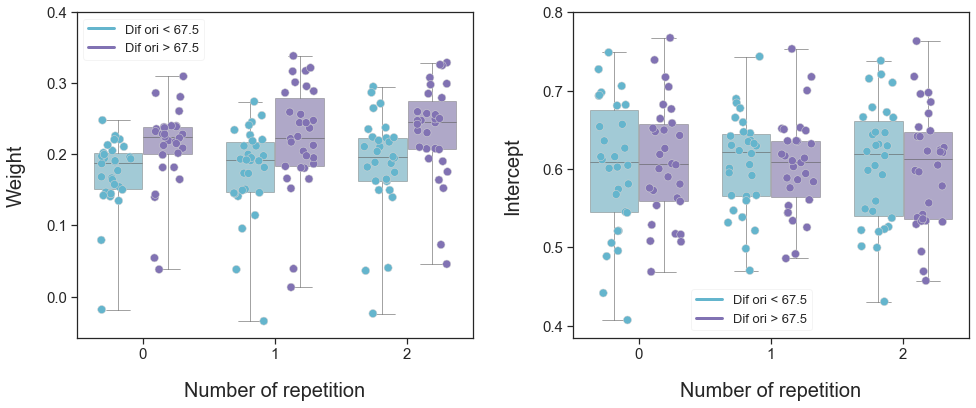

In [45]:
plt.subplots(ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace = 0.25)
dat = log_regpre_orient_params
mycol = ['c', 'm']
plt.subplot(1, 2, 1)  

ax = sns.boxplot(x="nrep", y="weight", hue = dat.pre_orient, linewidth = 0.55, dodge=True, data=dat, whis=np.inf, width = 0.75, boxprops=dict(alpha=.65), palette = mycol) # 
ax = sns.stripplot(x="nrep", y="weight", hue = dat.pre_orient, dodge=True, jitter=.25, data=dat, linewidth =.5, size=8, marker="o", edgecolor="lightgrey", alpha=1, palette = mycol)
plt.ylabel('Weight', fontsize = 20, labelpad=20); plt.yticks(np.arange(0, 0.41, step=0.1), fontsize = 15)
plt.xlabel('Number of repetition', fontdict={'size':20}, labelpad=20); plt.xticks(fontsize = 15)
ax.get_legend().remove()
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['Dif ori < 67.5', 'Dif ori > 67.5']; plt.legend(lines, labels, loc= 'upper left', fontsize=13, framealpha= 0.2)
                                                                            
plt.subplot(1, 2, 2)  #plt.figure(figsize=(2,5))
ax = sns.boxplot(x="nrep", y="intercept", hue = dat.pre_orient, linewidth = 0.55, dodge=True, data=dat, whis=np.inf, width = 0.75, boxprops=dict(alpha=.65), palette = mycol) # 
ax = sns.stripplot(x="nrep", y="intercept", hue = dat.pre_orient, dodge=True, jitter=.25, data=dat, linewidth =.5, size=8, marker="o", edgecolor='lightgrey', alpha=1, palette = mycol)
ax.get_legend().remove()
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['Dif ori < 67.5', 'Dif ori > 67.5']; plt.legend(lines, labels, bbox_to_anchor=(0.62,0.17), fontsize=13, framealpha= 0.2)
plt.ylabel('Intercept', fontsize = 20, labelpad=20); plt.yticks(np.arange(0.4, 0.81, step=0.1), fontsize = 15); plt.xlabel('Number of repetition', fontdict={'size':20}, labelpad=20); plt.xticks(fontsize = 15)
#plt.savefig('Orinetation_pre.png')

<font size="4"> _Weight en función de si la orientación fisica es similar o distinta a la anterior y el número de repetición._

In [46]:
# Stimulus following one similar orientated (do not differ in many degrees) are weighted less than others
# preceded by stimuli from distant orientations.

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
data = log_regpre_orient_params
dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another similar oriented in degrees
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#3FBFAA',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Dif ori < 67.5', # Stimuli followed by another similar in orientation
    marker_color='#3FBFAA'))
#0A4893

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another oriented very different in degrees
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#9F68E3', #violeta
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Dif ori > 67.5', # Stimuli followed by another very different in orientation
    marker_color='#9F68E3' #violeta
))

fig.update_layout(
    yaxis_title='Weight',
    boxmode='group' # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
fig.update_yaxes(tickvals= [0, 0.1, 0.2, 0.3], ticktext=['0','0.1', '0.2', '0.3'])

fig.update_layout(
    yaxis_title="Weight",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

<font size="3"> ANOVAs y post-hoc t-test para weight

In [47]:
#Checking statistical differences in Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'weight', within = ['nrep', 'pre_orient'], subject = 'npar', data=log_regpre_orient_params, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.010,2,58,0.005,7.134,1.697796e-03,2.623623e-03,0.197,0.889
1,pre_orient,0.084,1,29,0.084,40.864,5.458945e-07,5.458945e-07,0.585,1.000
2,nrep * pre_orient,0.001,2,58,0.000,1.398,2.553441e-01,2.555477e-01,0.046,0.946


In [48]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['nrep', 'pre_orient'], subject='npar', padjust='bonf', effsize = 'eta-square',interaction=False, data=log_regpre_orient_params) 
# de nuevo no puedo hacer la interacción

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,eta-square
0,nrep,0.0,1.0,True,True,-1.703,29.0,two-sided,9.928094e-02,0.297843,bonf,0.702,0.005
1,nrep,0.0,2.0,True,True,-3.357,29.0,two-sided,2.216073e-03,0.006648,bonf,16.474,0.024
2,nrep,1.0,2.0,True,True,-2.468,29.0,two-sided,1.973333e-02,0.059200,bonf,2.548,0.005
3,pre_orient,0.0,1.0,True,True,-6.392,29.0,two-sided,5.458945e-07,NaN,NaN,3.092e+04,0.109


Iteracciones con post hoc t tests

In [49]:
#para hacer la interacción he probado con lo siguiente
dat = log_regpre_orient_params.loc[log_regpre_orient_params.pre_orient == 0]
pg.pairwise_ttests(dv='weight', within=['nrep'], subject='npar', padjust='bonf', effsize = 'eta-square',interaction=False, data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,eta-square
0,nrep,0,1,True,True,-0.716,29.0,two-sided,0.479585,1.000000,bonf,0.246,0.001
1,nrep,0,2,True,True,-1.848,29.0,two-sided,0.074874,0.224623,bonf,0.872,0.012
2,nrep,1,2,True,True,-2.116,29.0,two-sided,0.043063,0.129189,bonf,1.348,0.005


In [50]:
dat = log_regpre_orient_params.loc[log_regpre_orient_params.pre_orient == 1]
pg.pairwise_ttests(dv='weight', within=['nrep'], subject='npar', padjust='bonf', effsize = 'eta-square',interaction=False, data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,eta-square
0,nrep,0,1,True,True,-1.993,29.0,two-sided,0.055714,0.167141,bonf,1.098,0.009
1,nrep,0,2,True,True,-3.992,29.0,two-sided,0.000409,0.001227,bonf,73.289,0.033
2,nrep,1,2,True,True,-1.887,29.0,two-sided,0.069147,0.207440,bonf,0.927,0.005


<font size="4"> _Bias en función de si la orientación fisica es similar o distinta a la anterior y el número de repetición._

In [51]:
# The same as before, with intercept instead of weight.

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
data = log_regpre_orient_params
dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another oriented very similar in degrees
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#3FBFAA',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Dif ori < 67.5', # Stimuli followed by another similar in orientation
    marker_color='#3FBFAA'))
#0A4893

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another oriented very different in degrees
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#9F68E3', #violeta
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Dif ori > 67.5', # Stimuli followed by another very different in orientation
    marker_color='#9F68E3' #violeta
))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Intercept'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
fig.update_yaxes(tickvals= [0.45, 0.55, 0.65, 0.75], ticktext=['0.45', '0.55', '0.65', '0.75'])

fig.update_layout(
    boxmode='group', # group together boxes of the different traces for each value of x
    yaxis_title="Intercept",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

<font size="3"> ANOVAs y post-hoc t-test para bias

In [52]:
#Checking statistical differences in Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_orient'], subject = 'npar', data=log_regpre_orient_params, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.000,2,58,0.000,0.178,0.837016,0.823528,0.006,0.938
1,pre_orient,0.000,1,29,0.000,0.020,0.889251,0.889251,0.001,1.000
2,nrep * pre_orient,0.001,2,58,0.001,3.688,0.031056,0.040391,0.113,0.822


Post-hoc t-test para mirar las interacciones

In [53]:
dat = log_regpre_orient_params.loc[log_regpre_orient_params.pre_orient == 0]

#aquí lo único significativo era la interacción, no podemos saber si la interacción entre la orientación previa es significativa con la 1a y la 2a, con la 2a y la 3a, o la 1 con la 3a
# de nuevo no puedo hacer la interacción
#así que he probado este invento, pero creo que no es una buena alternativa
pg.pairwise_ttests(dv='intercept', within=['nrep'], subject='npar', padjust='bonf', effsize = 'eta-square', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,eta-square
0,nrep,0,1,True,True,-0.718,29.0,two-sided,0.478367,1.0,bonf,0.246,0.002
1,nrep,0,2,True,True,-0.513,29.0,two-sided,0.611512,1.0,bonf,0.22,0.000
2,nrep,1,2,True,True,0.473,29.0,two-sided,0.639821,1.0,bonf,0.216,0.000


In [54]:
dat = log_regpre_orient_params.loc[log_regpre_orient_params.pre_orient == 1]

pg.pairwise_ttests(dv='intercept', within=['nrep'], subject='npar', padjust='bonf', effsize = 'eta-square', data=dat)

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,eta-square
0,nrep,0,1,True,True,0.802,29.0,two-sided,0.429086,1.00000,bonf,0.261,0.001
1,nrep,0,2,True,True,1.483,29.0,two-sided,0.148870,0.44661,bonf,0.521,0.004
2,nrep,1,2,True,True,0.650,29.0,two-sided,0.520989,1.00000,bonf,0.236,0.001


### Weight & Bias

<font size="3"> _Logisitc regression para plotear weight en función del bias y el número de repetición_

In [55]:
#generate dataframe to stimate the bias
# we want to stimate if participants with more weight, were more or less biased than participants with less weight
data = df
formula = "deci ~ rDV"
log_data = data.groupby(['npar','nrep', 'pre_deci']).apply(log_reg_fit, formula) 
log_data.reset_index(inplace = True) 

log_data.insert(6, 'pre_intercept', 0)
log_data['pre_intercept'] = log_data['intercept']
log_data['pre_intercept'] = log_data['pre_intercept'].shift(1, fill_value = 0)

log_data.insert(7, 'bias', 0) # this is to calculate the bias between previous decision cardinal and diagonal
log_data['bias'] = log_data['intercept'] - log_data['pre_intercept'] 

log_data.head()

,npar,nrep,pre_deci,level_3,intercept,weight,pre_intercept,bias
0,1.0,0,0,0,0.604123,0.642526,0.000000,0.604123
1,1.0,0,1,0,0.644931,0.660138,0.604123,0.040809
2,1.0,1,0,0,0.397771,0.712483,0.644931,-0.247161
3,1.0,1,1,0,0.806646,0.377434,0.397771,0.408875
4,1.0,2,0,0,0.310657,0.466384,0.806646,-0.495989


In [56]:
formula = "deci ~ rDV"
log_data2 = data.groupby(['npar','nrep']).apply(log_reg_fit, formula)
log_data2.reset_index(inplace = True)
log_data2[['npar', 'nrep', 'intercept']] 
log_data2.head()

bias = log_data[['npar', 'bias', 'pre_deci', 'nrep']]
bias = bias.loc[(bias.pre_deci == 1),:] 
# i took pre_deci 1 as bias, because it is the result of the bias within the participant, 0 is not useful.
# it computes the bias between two different participants
bias = bias[['bias']]
bias.reset_index(drop=True, inplace=True)
bias.head()

bias = pd.concat([log_data2, bias], axis=1)
bias.head()

,npar,nrep,level_2,intercept,weight,bias
0,1.0,0,0,0.630730,0.653240,0.040809
1,1.0,1,0,0.625085,0.758359,0.408875
2,1.0,2,0,0.621639,0.771317,0.516266
3,2.0,0,0,0.666418,0.813619,0.030096
4,2.0,1,0,0.593057,1.078703,0.639009


<font size="4"> _Weight en función del bias por el número de repetición._

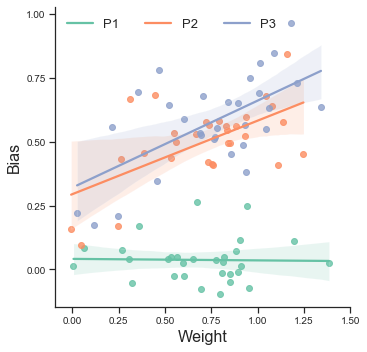

In [57]:
# in this plot, we can see how the best participants (those with higher weight) were more biased in 2nd a 3rd presentation
# to answer consistent with previous decision
sns.lmplot(x='weight', y='bias', data = bias, fit_reg = True, hue = 'nrep', legend = False, palette='Set2')

plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 10); plt.xticks(np.arange(0, 1.6, step=0.25), fontsize = 10)

plt.legend(loc='upper left', frameon=False,labels=['P1', 'P2', 'P3'], fontsize=13, title_fontsize=14, ncol=3); plt.ylabel('Bias', fontsize = 16); plt.xlabel('Weight', fontdict={'size':16}); 
#plt.savefig('biasvsweightEND.png')

<font size="3"> Analisis estadístico

In [58]:
#He tenido problemas para saber qué estadístico era el mejor 
#para mrar si había diferencias significativas en el plot anterior/ He probado diferentes estadísticos...

mdf = smf.mixedlm("bias ~ weight * C(nrep)", bias, groups = bias["npar"]).fit()
mdf.summary()

C:\Users\usuario\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:               MixedLM    Dependent Variable:    bias   
No. Observations:    90         Method:                REML   
No. Groups:          30         Scale:                 0.0114 
Min. group size:     3          Log-Likelihood:        52.3600
Max. group size:     3          Converged:             Yes    
Mean group size:     3.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.049    0.056  0.875 0.382 -0.061  0.158
C(nrep)[T.1]         0.255    0.068  3.744 0.000  0.122  0.389
C(nrep)[T.2]         0.274    0.069  3.967 0.000  0.139  0.410
weight              -0.017    0.075 -0.222 0.824 -0.163  0.130
weight:C(nrep)[T.1]  0.290    0.089  3.246 0.001  0.115  0.466
weight:C(nrep)[T.2]  0.353    0.088  3.990 0.000  0.180  0.526
Group Var            0.004    0.023                           
==============================================================

"""

In [59]:
mod = ols(formula='weight ~ bias * nrep', data=bias)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     9.160
Date:                Sat, 09 May 2020   Prob (F-statistic):           2.52e-05
Time:                        16:57:44   Log-Likelihood:                -12.101
No. Observations:                  90   AIC:                             32.20
Df Residuals:                      86   BIC:                             42.20
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6661      0.054     12.240      0.0

<font size="3"> _Logisitc regression para plotear bias en función de si la respuesta anterior era correcta_

In [60]:
# we make a similar analyses than before, but know we stimated biased between previous answer correct/incorrect
# we wanted to stimate if participants were more biased when the previous answer was correct or incorrect
data = df
formula = "deci ~ rDV"
log_data = data.groupby(['pre_correct','npar', 'pre_deci']).apply(log_reg_fit, formula)
log_data.reset_index(inplace = True)

log_data.insert(6, 'pre_intercept', 0)
log_data['pre_intercept'] = log_data['intercept']
log_data['pre_intercept'] = log_data['pre_intercept'].shift(1, fill_value = 0)

log_data.insert(7, 'bias', 0)
log_data['bias'] = log_data['intercept'] - log_data['pre_intercept'] 

log_data.head()

,pre_correct,npar,pre_deci,level_3,intercept,weight,pre_intercept,bias
0,0,1.0,0,0,0.372820,0.898582,0.000000,0.372820
1,0,1.0,1,0,0.817328,0.542924,0.372820,0.444508
2,0,2.0,0,0,0.329550,0.872238,0.817328,-0.487778
3,0,2.0,1,0,0.869423,0.631504,0.329550,0.539873
4,0,3.0,0,0,0.377428,1.033978,0.869423,-0.491995


In [61]:
formula = "deci ~ rDV"
log_data2 = data.groupby(['pre_correct','npar']).apply(log_reg_fit, formula)
log_data2.reset_index(inplace = True)
log_data2[['pre_correct', 'npar', 'intercept']]
log_data2.head()

bias2 = log_data[['pre_correct', 'bias', 'pre_deci', 'npar']]
bias2 = bias2.loc[(bias2.pre_deci == 1),:]
bias2 = bias2[['bias']]
bias2.reset_index(drop=True, inplace=True)
bias2.head()

bias2 = pd.concat([log_data2, bias2], axis=1)
biaspre_correct = bias2
biaspre_correct.head()

,pre_correct,npar,level_2,intercept,weight,bias
0,0,1.0,0,0.695250,0.293640,0.444508
1,0,2.0,0,0.695052,0.183391,0.539873
2,0,3.0,0,0.685650,0.254049,0.357022
3,0,4.0,0,0.595836,0.316207,0.431877
4,0,5.0,0,0.508792,0.002194,0.437454


<font size="4"> _Bias en función de si la respuesta anterior era correcta o no_

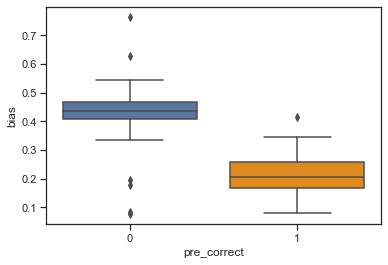

In [62]:
# Next, I will plot if there is more bias after an error, or after correct answers

# habría que hacer un plot mejor, la única cosa es que no me deja hacer el log_reg_fit poniendo nrep. Porque no admite más variables
plt.plot(figsize = (7,10))

sns.boxplot(x='pre_correct', y='bias', data =biaspre_correct)

In [63]:
#The same boxplot with Plotly

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])

dat = biaspre_correct.loc[(biaspre_correct.pre_correct == 0),:]
fig.add_trace(go.Box(
    y=dat['bias'],
    boxpoints='all',
    whiskerwidth=0.5,
    width = 0,
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#FFDCA2', # sand
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.1,
    name='Incorrect', # Stimuli followed by another similar in orientation
    marker_color='#FFDCA2')) # sand
#0A4893

dat = biaspre_correct.loc[(biaspre_correct.pre_correct == 1),:]
fig.add_trace(go.Box(
    y=dat['bias'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.5,
    width = 0,
    marker=dict(
        color='#4385BB', #dark blue #4385BB  #355C7D
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.1, 
    name='Correct', # Stimuli followed by another very different in orientation
    marker_color='#4385BB' #dark blue
))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Intercept'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0], ticktext=[' ', '2'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
fig.update_yaxes(tickvals= [0.1, 0.3, 0.5, 0.7], ticktext=['0.1', '0.3', '0.5', '0.7'])


fig.update_layout(
    legend=dict(
        x=0.62,
        y=0.9,
        traceorder="normal",
        font=dict(
            family="verdana",
            size=18,
            color="#54636D"
        )))

fig.update_layout(
    yaxis_title="Bias",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)

fig.show()

<font size="3"> t-test para el bias en función de la respuesta anterior (correcta o incorrecra)

In [64]:
# pairwaise t test
pg.pairwise_ttests(dv='bias', within=['pre_correct'], subject='npar', padjust='none', effsize = 'cohen', data=biaspre_correct) 
# parece que no es significativo. Estos son los análisis que me pediste (los últimos). 
# Comparar el bias cuando la respuesta previa era correcta o incorrecta

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,pre_correct,0,1,True,True,8.591,29.0,two-sided,1.835212e-09,6.399e+06,1.906


In [65]:
# we make a similar analyses than before, but know we stimated biased between previous answer correct/incorrect
# we wanted to stimate if participants were more biased when the previous answer was correct or incorrect

# i tried to incorporate nrep, but until now it is not working
# here it is the best try, but it provides results that seems contradictory to me compared with the previous plot
data = df
formula = "deci ~ rDV"
log_data = data.groupby(['pre_correct','nrep', 'pre_deci']).apply(log_reg_fit, formula)
log_data.reset_index(inplace = True)

log_data.insert(6, 'pre_intercept', 0)
log_data['pre_intercept'] = log_data['intercept']
log_data['pre_intercept'] = log_data['pre_intercept'].shift(1, fill_value = 0)

log_data.insert(7, 'bias', 0)
log_data['bias'] = log_data['intercept'] - log_data['pre_intercept'] 

log_data.head()

,pre_correct,nrep,pre_deci,level_3,intercept,weight,pre_intercept,bias
0,0,0,0,0,0.563997,0.328207,0.000000,0.563997
1,0,0,1,0,0.617995,0.487722,0.563997,0.053998
2,0,1,0,0,0.205885,0.667926,0.617995,-0.412110
3,0,1,1,0,0.910330,0.610840,0.205885,0.704445
4,0,2,0,0,0.153043,0.653725,0.910330,-0.757287


In [66]:
formula = "deci ~ rDV"
log_data2 = data.groupby(['pre_correct','nrep']).apply(log_reg_fit, formula)
log_data2.reset_index(inplace = True)
log_data2[['pre_correct', 'nrep', 'intercept']]
log_data2.head()

bias2 = log_data[['pre_correct', 'bias', 'pre_deci', 'nrep']]
bias2 = bias2.loc[(bias2.pre_deci == 1),:]
bias2 = bias2[['bias']]
bias2.reset_index(drop=True, inplace=True)
bias2.head()

bias2 = pd.concat([log_data2, bias2], axis=1)
bias2.head()

,pre_correct,nrep,level_2,intercept,weight,bias
0,0,0,0,0.599562,0.433948,0.053998
1,0,1,0,0.599197,-0.213390,0.704445
2,0,2,0,0.595617,-0.305943,0.790762
3,1,0,0,0.609810,0.591393,0.056067
4,1,1,0,0.559626,0.886900,0.824545


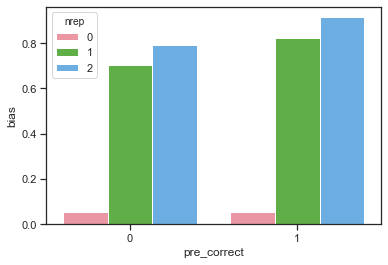

In [67]:
#I don't think this is correct, because (I think)it is contradictory with the last plot. And I forced the code to give a result.
plt.plot(figsize = (7,10))

sns.barplot(x='pre_correct', y='bias', hue='nrep', data =bias2)

aqui parece que hay mas bias cuando en el trial anterior la gente respondia correctamente. Sin embargo en la figura de arriba (naranja y azul bloxplot) parecia al reves. Por qué?

yo tampoco lo entiendo. para mí no tiene mucho sentido la verdad

### Data anlysis and plots by stimuli

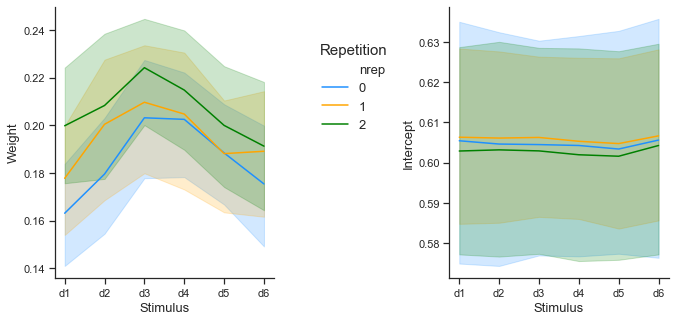

In [68]:
plt.subplots(ncols=2, figsize=(11, 5))
plt.subplots_adjust(wspace = 0.8) #wspace sirve para marcar la separación entre los dos plots 
#con un valor negativo te cargas el primer plot

plt.subplot(1, 2, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="weight", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)

plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Weight', fontsize= 13)
legend =plt.legend(frameon=False, title = 'Rep')
legend.remove()


plt.subplot(1, 2, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="intercept", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)
plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Intercept', fontsize= 13)
#plt.legend(frameon=False)
plt.legend(loc='lower right', frameon=False,
          bbox_to_anchor=(0.56
                          , 0.5), title='Repetition', fontsize=13, title_fontsize=15,
          bbox_transform=plt.gcf().transFigure)
sns.despine(top=True)
#plt.savefig('stim_wewight&intercept.png')

In [69]:
# ANOVA to check if there are differences in the how stimuli are WEIGHTED depending on their position

pg.rm_anova(dv = 'weight', within = ['nrep', 'stim'], subject = 'npar', data=log_regstim_params, detailed = True, correction = True)

C:\Users\usuario\anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.040,2,58,0.020,10.607,0.000119,0.000377,0.268,0.817
1,stim,0.070,5,145,0.014,2.899,0.015885,0.023293,0.091,0.830
2,nrep * stim,0.011,10,290,0.001,1.487,0.143482,0.209133,0.049,0.412


In [70]:
# post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['nrep', 'stim'], subject='npar', padjust='bonf', effsize = 'cohen', interaction=False, data=log_regstim_params) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,-2.071,29.0,two-sided,0.047396,0.142189,bonf,1.248,-0.173
1,nrep,0,2,True,True,-3.899,29.0,two-sided,0.000526,0.001578,bonf,58.546,-0.376
2,nrep,1,2,True,True,-3.291,29.0,two-sided,0.002629,0.007887,bonf,14.194,-0.181
3,stim,d1,d2,True,True,-1.545,29.0,two-sided,0.133307,1.000000,bonf,0.564,-0.235
4,stim,d1,d3,True,True,-3.403,29.0,two-sided,0.001965,0.029481,bonf,18.296,-0.507
5,stim,d1,d4,True,True,-2.688,29.0,two-sided,0.011791,0.176865,bonf,3.919,-0.419
6,stim,d1,d5,True,True,-1.225,29.0,two-sided,0.230474,1.000000,bonf,0.384,-0.196
7,stim,d1,d6,True,True,-0.518,29.0,two-sided,0.608540,1.000000,bonf,0.22,-0.076
8,stim,d2,d3,True,True,-1.486,29.0,two-sided,0.148068,1.000000,bonf,0.523,-0.231
9,stim,d2,d4,True,True,-1.178,29.0,two-sided,0.248238,1.000000,bonf,0.365,-0.157


In [71]:
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position

pg.rm_anova(dv = 'intercept', within = ['nrep', 'stim'], subject = 'npar', data=log_regstim_params, detailed = True, correction = True)

C:\Users\usuario\anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.001,2,58,0.0,0.142,0.868247,0.852171,0.005,0.922
1,stim,0.000,5,145,0.0,0.421,0.833271,0.804569,0.014,0.852
2,nrep * stim,0.000,10,290,0.0,1.192,0.295750,0.297277,0.039,0.133


In [72]:
#logistic regression to estimate weight and intercept parameters with previous decision by stimuli
formula = "deci ~ dv"

log_regstim_params_preD = dflong.groupby(['npar','nrep', 'stim', 'pre_deci']).apply(log_reg_fit, formula)
log_regstim_params_preD.reset_index(inplace = True)

dat = log_regstim_params_preD

dat.insert(7, 'pre_weight', 0)
dat['pre_weight'] = dat['weight']
dat['pre_weight'] = dat['pre_weight'].shift(1, fill_value = 0)

dat.insert(8, 'w_dif', 0)
dat['w_dif'] = dat['weight'] - dat['pre_weight']

dat.insert(9, 'pre_int', 0)
dat['pre_int'] = dat['intercept']
dat['pre_int'] = dat['pre_int'].shift(1, fill_value = 0)

dat.insert(10, 'i_dif', 0)
dat['i_dif'] = dat['intercept'] - dat['pre_int']

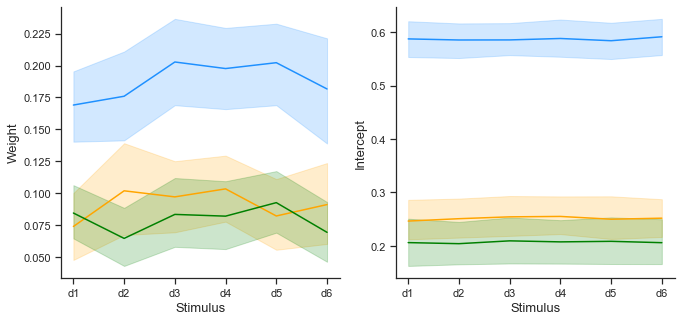

In [73]:
# it plots weight and intercept depending on the previous decision, when previous was cardinal by stimuli
plt.subplots(ncols=2, figsize=(11, 5))
plt.subplots_adjust(wspace = 0.2) #wspace antes 0.5

plt.subplot(1, 2, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="weight", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params_preD.loc[(log_regstim_params_preD.pre_deci == 0),:])
plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Weight', fontsize= 13)
legend =plt.legend(frameon=False, title = 'Rep')
legend.remove()
plt.subplot(1, 2, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="intercept", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params_preD.loc[(log_regstim_params_preD.pre_deci == 0),:])
plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Intercept', fontsize= 13)
legend =plt.legend(loc='lower right', frameon=False,
          bbox_to_anchor=(0.56, 0.5), title='Repetition', fontsize=13, title_fontsize=15,
          bbox_transform=plt.gcf().transFigure)
legend.remove()
sns.despine(top=True)

In [74]:
# weight
dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 0];
#aov_log_preg_preD_car = AnovaRM(dat, 'weight', 'npar', within = ['nrep', 'stim']).fit()
print('How stimuli are weighted depending on their order in the sequence' 
      ' and the number of presentation when the previous decision was cardinal')
pg.rm_anova(dv = 'weight', within = ['nrep', 'stim'], subject = 'npar', data=dat, detailed = True, correction = True)

How stimuli are weighted depending on their order in the sequence and the number of presentation when the previous decision was cardinal


C:\Users\usuario\anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,1.282,2,58,0.641,67.879,6.440233e-16,3.499322e-15,0.701,0.946
1,stim,0.031,5,145,0.006,1.197,3.134952e-01,3.157364e-01,0.040,0.814
2,nrep * stim,0.038,10,290,0.004,0.936,4.999577e-01,4.592060e-01,0.031,0.499


In [90]:
#post-hoc parwaise t-test
dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 0];
pg.pairwise_ttests(dv='weight', within=['nrep'], subject='npar', padjust='bonf', effsize = 'cohen', interaction=False, data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,12.699,179.0,two-sided,9.292414e-27,2.787724e-26,bonf,3.871e+23,1.070
1,nrep,0,2,True,True,14.537,179.0,two-sided,4.010768e-32,1.203230e-31,bonf,7.507e+28,1.324
2,nrep,1,2,True,True,1.730,179.0,two-sided,8.536318e-02,2.560895e-01,bonf,0.359,0.159


In [76]:
# intercept
dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 0];
#aov_log_preg_preDI_car = AnovaRM(dat, 'intercept', 'npar', within = ['nrep', 'stim']).fit()
print('Intercept changes depending on their order in the sequence' 
      ' and the number of presentation when the previous decision was       cardinal')

pg.rm_anova(dv = 'intercept', within = ['nrep', 'stim'], subject = 'npar', data=dat, detailed = True, correction = True)

Intercept changes depending on their order in the sequence and the number of presentation when the previous decision was       cardinal


C:\Users\usuario\anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,15.567,2,58,7.783,148.558,1.509029e-23,5.500021e-17,0.837,0.691
1,stim,0.001,5,145,0.000,1.026,4.044522e-01,3.984624e-01,0.034,0.838
2,nrep * stim,0.002,10,290,0.000,1.520,1.315376e-01,2.293126e-01,0.050,0.085


In [89]:
#post-hoc parwaise t-test
dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 0];
pg.pairwise_ttests(dv='intercept', within=['nrep'], subject='npar', padjust='bonf', effsize = 'cohen', interaction=False, data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,29.956,179.0,two-sided,1.215773e-71,3.647318e-71,bonf,1.014e+68,3.380
1,nrep,0,2,True,True,33.572,179.0,two-sided,3.618694e-79,1.085608e-78,bonf,2.993e+75,3.563
2,nrep,1,2,True,True,7.825,179.0,two-sided,4.267782e-13,1.280335e-12,bonf,1.584e+10,0.399


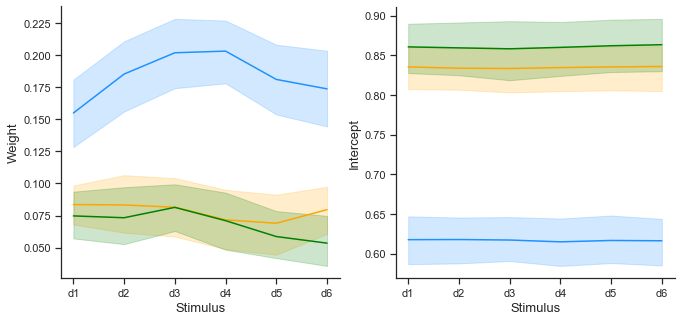

In [78]:
# it plots weight and intercept depending on the previous decision, when previous was diagonal by stimuli
plt.subplots(ncols=2, figsize=(11, 5))
plt.subplots_adjust(wspace = 0.2) #wspace previous 0.5
#con un valor negativo te cargas el primer plot

plt.subplot(1, 2, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="weight", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params_preD.loc[(log_regstim_params_preD.pre_deci == 1),:])
plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Weight', fontsize= 13)
legend =plt.legend(frameon=False, title = 'Rep')
legend.remove()
plt.subplot(1, 2, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="intercept", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params_preD.loc[(log_regstim_params_preD.pre_deci == 1),:])
plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Intercept', fontsize= 13)
legend=plt.legend(loc='lower right', frameon=False,
          bbox_to_anchor=(0.56, 0.5), title='Repetition', fontsize=13, title_fontsize=15,
          bbox_transform=plt.gcf().transFigure)
legend.remove()
sns.despine(top=True)

In [79]:
# weight

dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 1];
#aov_log_preg_preD_diag = AnovaRM(dat, 'weight', 'npar', within = ['nrep', 'stim']).fit()
print('How stimuli are weighted depending on their order in the sequence' 
      ' and the number of presentation when the previous decision was diagonal')

pg.rm_anova(dv = 'weight', within = ['nrep', 'stim'], subject = 'npar', data=dat, detailed = True, correction = True)

How stimuli are weighted depending on their order in the sequence and the number of presentation when the previous decision was diagonal


C:\Users\usuario\anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,1.456,2,58,0.728,72.966,1.460089e-16,1.067076e-14,0.716,0.869
1,stim,0.029,5,145,0.006,2.437,3.734455e-02,4.681041e-02,0.078,0.855
2,nrep * stim,0.043,10,290,0.004,1.770,6.572618e-02,1.364427e-01,0.058,0.418


In [80]:
#post-hoc parwaise t-test
dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 1];
pg.pairwise_ttests(dv='weight', within=['nrep', 'stim'], subject='npar', padjust='bonf', effsize = 'cohen', interaction=False, data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,9.330,29.0,two-sided,3.107614e-10,9.322842e-10,bonf,3.423e+07,2.144
1,nrep,0,2,True,True,9.777,29.0,two-sided,1.097095e-10,3.291285e-10,bonf,9.17e+07,2.354
2,nrep,1,2,True,True,1.129,29.0,two-sided,2.682878e-01,8.048635e-01,bonf,0.347,0.208
3,stim,d1,d2,True,True,-1.384,29.0,two-sided,1.769328e-01,1.000000e+00,bonf,0.46,-0.216
4,stim,d1,d3,True,True,-3.225,29.0,two-sided,3.110371e-03,4.665556e-02,bonf,12.264,-0.455
5,stim,d1,d4,True,True,-1.670,29.0,two-sided,1.057149e-01,1.000000e+00,bonf,0.67,-0.275
6,stim,d1,d5,True,True,0.195,29.0,two-sided,8.467670e-01,1.000000e+00,bonf,0.198,0.038
7,stim,d1,d6,True,True,0.319,29.0,two-sided,7.516882e-01,1.000000e+00,bonf,0.204,0.053
8,stim,d2,d3,True,True,-0.996,29.0,two-sided,3.276961e-01,1.000000e+00,bonf,0.306,-0.170
9,stim,d2,d4,True,True,-0.193,29.0,two-sided,8.485816e-01,1.000000e+00,bonf,0.198,-0.028


In [81]:
# intercept

dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 1];

#aov_log_preg_preDI_diag = AnovaRM(dat, 'intercept', 'npar', within = ['nrep', 'stim']).fit()
print('Intercept changes depending on their order in the sequence' 
      ' and the number of presentation when the previous decision was       diagonal')

pg.rm_anova(dv = 'intercept', within = ['nrep', 'stim'], subject = 'npar', data=dat, detailed = True, correction = True)

Intercept changes depending on their order in the sequence and the number of presentation when the previous decision was       diagonal


C:\Users\usuario\anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,6.464,2,58,3.232,163.013,1.559438e-24,1.469471e-15,0.849,0.596
1,stim,0.000,5,145,0.000,1.041,3.957738e-01,3.901501e-01,0.035,0.827
2,nrep * stim,0.000,10,290,0.000,1.231,2.702831e-01,2.796482e-01,0.041,0.073


In [91]:
#post-hoc parwaise t-test
dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 1];
pg.pairwise_ttests(dv='intercept', within=['nrep'], subject='npar', padjust='bonf', effsize = 'cohen', interaction=False, data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,-30.152,179.0,two-sided,4.571026e-72,1.371308e-71,bonf,2.677e+68,-2.717
1,nrep,0,2,True,True,-34.753,179.0,two-sided,1.679759e-81,5.039278e-81,bonf,6.202e+77,-2.803
2,nrep,1,2,True,True,-10.105,179.0,two-sided,2.787493e-19,8.362479e-19,bonf,1.744e+16,-0.302


#### Bins intercept and weight plots

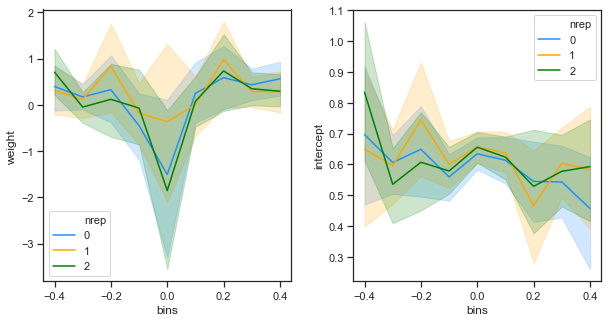

In [83]:
formula = "deci ~ dv"

log_regbinned_params = dflong.groupby(['npar','nrep', 'bins', 'cond']).apply(log_reg_fit, formula)
log_regbinned_params.reset_index(inplace = True)
dat = log_regbinned_params

plt.subplots(ncols=2, figsize=(10, 5))
plt.subplots_adjust(wspace = 0.25)

plt.subplot(1, 2, 1) 
sns.lineplot(x="bins", y="weight",
             hue="nrep",
             palette= ["dodgerblue", "orange", "green"],
             data=dat)
plt.subplot(1, 2, 2)  
sns.lineplot(x="bins", y="intercept",
             hue="nrep",
             palette= ["dodgerblue", "orange", "green"],
             data=dat)

In [84]:
# weight by bins and nrep

pg.rm_anova(dv = 'weight', within = ['nrep', 'bins'], subject = 'npar', data=log_regbinned_params, detailed = True, correction = True)

C:\Users\usuario\anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,7.069,2,58,3.534,3.217,0.047335,0.047429,0.100,0.998
1,bins,246.691,8,232,30.836,2.533,0.011632,0.062016,0.080,0.376
2,nrep * bins,48.214,16,464,3.013,1.582,0.069625,0.201930,0.052,0.178


In [92]:
#post-hoc parwaise t-test

pg.pairwise_ttests(dv='weight', within=['nrep', 'bins'], subject='npar', padjust='bonf', effsize = 'cohen', interaction=False, data=log_regbinned_params) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0.0,1.0,True,True,-1.846,29.0,two-sided,0.075186,0.225558,bonf,0.869,-0.266
1,nrep,0.0,2.0,True,True,0.581,29.0,two-sided,0.565497,1.000000,bonf,0.227,0.078
2,nrep,1.0,2.0,True,True,2.555,29.0,two-sided,0.016114,0.048341,bonf,3.016,0.344
3,bins,-0.4,-0.3,True,True,1.362,29.0,two-sided,0.183820,1.000000,bonf,0.448,0.373
4,bins,-0.4,-0.2,True,True,0.088,29.0,two-sided,0.930183,1.000000,bonf,0.195,0.026
5,bins,-0.4,-0.1,True,True,1.753,29.0,two-sided,0.090126,1.000000,bonf,0.756,0.459
6,bins,-0.4,0.0,True,True,2.035,29.0,two-sided,0.051130,1.000000,bonf,1.175,0.620
7,bins,-0.4,0.1,True,True,0.982,29.0,two-sided,0.334199,1.000000,bonf,0.302,0.266
8,bins,-0.4,0.2,True,True,-0.630,29.0,two-sided,0.533393,1.000000,bonf,0.233,-0.174
9,bins,-0.4,0.3,True,True,0.408,29.0,two-sided,0.686168,1.000000,bonf,0.21,0.109


In [86]:
# intercept by bins and nrep

pg.rm_anova(dv = 'intercept', within = ['nrep', 'bins'], subject = 'npar', data=log_regbinned_params, detailed = True, correction = True)

C:\Users\usuario\anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.120,2,58,0.060,1.005,0.372369,0.372106,0.033,0.996
1,bins,3.183,8,232,0.398,1.005,0.432722,0.406062,0.034,0.481
2,nrep * bins,1.369,16,464,0.086,1.654,0.052390,0.173461,0.054,0.221
